## Set animal ID and directory path

In [11]:
%%capture
%load_ext autoreload
%autoreload 2
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from datetime import datetime
import json
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
import pickle
from scipy.signal import find_peaks
import seaborn as sns

import npa_functions as npa
import behavior_epochs_functions as behav
import auROC_functions as auROC

# Example usage

parent_path = "C:\\temp minian analysis\\minian"  # parent directory to loop through
neural_imaging_subfolder = ''  # subfolders containing folders with miniscope videos

animal_ids = ['B2_DAT3']  # List of animal_ids to loop through #stress = ['DP9', 'DP11', 'DP14'] non-stress = ['DP10', 'DP12', 'DP15']

test_ids = []  # Replace with the actual animal IDs to plot
ctrl_ids = [] # Replace with the actual animal IDs to plot


## Optional: Print general info from nc file (ie Minian output)

In [12]:
for animal_id in animal_ids:
    npa.get_info_nc_file_in_animal_folder(parent_path, animal_id, neural_imaging_subfolder)

Opening and reading components of C:\temp minian analysis\minian\B2_DAT3\B2_DAT3.nc
Dimensions:
unit_id: 283
height: 600
width: 600
frame: 2000

Variables:


## Optional: For single animal, get specific calcium imaging variable (ie raw, deconvolved, spikes) with option to visualize 

In [24]:
example_animal_id='B2_DAT3'
# Extract and binarize behavioral bouts
#ex_raw_dataset = npa.get_variable_in_nc_file(parent_path, example_animal_id, neural_imaging_subfolder, variable_name='YrA', plot=False)
ex_spike_dataset = npa.get_variable_in_nc_file(parent_path, example_animal_id, neural_imaging_subfolder, variable_name='A', plot=False)
ex_deconvolved_dataset = npa.get_variable_in_nc_file(parent_path, example_animal_id, neural_imaging_subfolder, variable_name='C', plot=False)


Opening and reading components of C:\temp minian analysis\minian\B2_DAT3\B2_DAT3.nc
unit_id: (283,) 
animal: () 
height: (600,) 
session: () 
unit_labels: (283,) 
width: (600,) 
A: (283, 600, 600) 
b: (600, 600) 
frame: (2000,) 
b0: (283, 2000) 
C: (283, 2000) 
c0: (283, 2000) 
f: (2000,) 
max_proj: (600, 600) 
S: (283, 2000) 
YrA: (283, 2000) 
Opening and reading components of C:\temp minian analysis\minian\B2_DAT3\B2_DAT3.nc
unit_id: (283,) 
animal: () 
height: (600,) 
session: () 
unit_labels: (283,) 
width: (600,) 
A: (283, 600, 600) 
b: (600, 600) 
frame: (2000,) 
b0: (283, 2000) 
C: (283, 2000) 
c0: (283, 2000) 
f: (2000,) 
max_proj: (600, 600) 
S: (283, 2000) 
YrA: (283, 2000) 


(283, 2000)


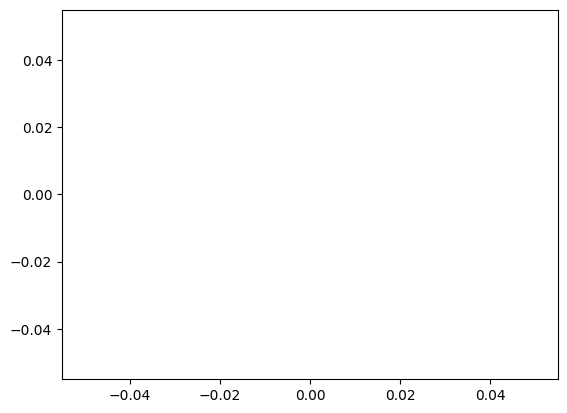

In [31]:
def plot_data(data, variable_name):
    plt.figure(figsize=(10, 5))
    #for col_idx in range(data.shape[0]):
        #plt.plot(data[col_idx,:] + col_idx * 10, label=f'Column {col_idx + 1}')
    plt.plot(data[:,1] + 1 * 10, label=f'Column {1 + 1}')

    plt.title(variable_name)
    plt.xlabel('Frames')
    plt.ylabel('Fluorescence (A.U)')
    
#plot_data(example_animal_raw_dataset, 'YrA')

data=ex_deconvolved_dataset
print(data.shape)
plt.plot(data[:,1999])

## Get specific calcium imaging variable (ie raw, deconvolved, spikes) with option to visualize 

In [9]:
# Initialize empty lists to store results for each animal_id
all_datasets = []
all_spike_datasets=[]
all_deconvolved_datasets=[]
for animal_id in animal_ids:
    # Extract and binarize behavioral bouts
    dataset = npa.get_variable_in_nc_file(parent_path, animal_id, neural_imaging_subfolder, variable_name='YrA', plot=False)
    spike_dataset = npa.get_variable_in_nc_file(parent_path, animal_id, neural_imaging_subfolder, variable_name='A', plot=False)
    deconvolved_dataset = npa.get_variable_in_nc_file(parent_path, animal_id, neural_imaging_subfolder, variable_name='C', plot=False)
    all_datasets.append(dataset)
    all_spike_datasets.append(spike_dataset)
    all_deconvolved_datasets.append(deconvolved_dataset)

test_datasets = []
test_spike_datasets=[]
test_deconvolved_datasets=[]
for test_id in test_ids:
    # Extract and binarize behavioral bouts
    dataset = npa.get_variable_in_nc_file(parent_path, test_id, neural_imaging_subfolder, variable_name='YrA', plot=False)
    spike_dataset = npa.get_variable_in_nc_file(parent_path, test_id, neural_imaging_subfolder, variable_name='A', plot=False)
    deconvolved_dataset = npa.get_variable_in_nc_file(parent_path, test_id, neural_imaging_subfolder, variable_name='C', plot=False)
    test_datasets.append(dataset)
    test_spike_datasets.append(spike_dataset)
    test_deconvolved_datasets.append(deconvolved_dataset)

ctrl_datasets = []
ctrl_spike_datasets=[]
ctrl_deconvolved_datasets=[]
for ctrl_id in ctrl_ids:
    # Extract and binarize behavioral bouts
    dataset = npa.get_variable_in_nc_file(parent_path, ctrl_id, neural_imaging_subfolder, variable_name='YrA', plot=False)
    spike_dataset = npa.get_variable_in_nc_file(parent_path, ctrl_id, neural_imaging_subfolder, variable_name='A', plot=False)
    deconvolved_dataset = npa.get_variable_in_nc_file(parent_path, ctrl_id, neural_imaging_subfolder, variable_name='C', plot=False)
    ctrl_datasets.append(dataset)
    ctrl_spike_datasets.append(spike_dataset)
    ctrl_deconvolved_datasets.append(deconvolved_dataset)

Opening and reading components of Z:\DPC HONGWEI COLAB\DP2\all\img\minian\DP2.nc
unit_id: (145,) 
animal: () 
height: (600,) 
session: () 
width: (600,) 
A: (145, 600, 600) 
b: (600, 600) 
frame: (14340,) 
b0: (145, 14340) 
C: (145, 14340) 
c0: (145, 14340) 
f: (14340,) 
max_proj: (600, 600) 
shift_dim: (2,) 
motion: (14340, 2) 
S: (145, 14340) 
YrA: (145, 14340) 
Opening and reading components of Z:\DPC HONGWEI COLAB\DP2\all\img\minian\DP2.nc
unit_id: (145,) 
animal: () 
height: (600,) 
session: () 
width: (600,) 
A: (145, 600, 600) 
b: (600, 600) 
frame: (14340,) 
b0: (145, 14340) 
C: (145, 14340) 
c0: (145, 14340) 
f: (14340,) 
max_proj: (600, 600) 
shift_dim: (2,) 
motion: (14340, 2) 
S: (145, 14340) 
YrA: (145, 14340) 
Opening and reading components of Z:\DPC HONGWEI COLAB\DP2\all\img\minian\DP2.nc
unit_id: (145,) 
animal: () 
height: (600,) 
session: () 
width: (600,) 
A: (145, 600, 600) 
b: (600, 600) 
frame: (14340,) 
b0: (145, 14340) 
C: (145, 14340) 
c0: (145, 14340) 
f: (143

# Extract and binarize behavioral events

## Option 1: Extract from manually scored behavior (ie annotator.ipynb)

In [ ]:
# Initialize empty lists to store results for each animal_id
all_interaction_bouts = []
all_non_interaction_bouts = []
all_interaction_vectors = []
all_non_interaction_vectors = []

for animal_id in animal_ids:
    # Extract and binarize behavioral bouts
    
    video_duration, video_fps, frame_timestamps, interaction_bouts, non_interaction_bouts, interaction_vector, non_interaction_vector = npa.extract_and_binarize_behavior(parent_path, animal_id)
    all_interaction_bouts.append(interaction_bouts)
    all_non_interaction_bouts.append(non_interaction_bouts)
    all_interaction_vectors.append(interaction_vector)
    all_non_interaction_vectors.append(non_interaction_vector)


## Option 2: Extract from position data (ie DeepLabCut)

**Optional: open position data file**

In [ ]:
open_position_data = True  # Set this to True if you want the loop to execute

for animal_id in animal_ids:
    # Check if the specified variable is present
    if open_position_data:  # No need for "== True"
        position_data = os.path.join(parent_path, animal_id, 'all\\behav\\positions.h5')
        df = pd.read_hdf(position_data)
        df.head()

**Extract position data**

In [10]:
#body_part_pairs = [('Nose', 'Center'),('Nose', 'Tail_base'),('Nose', 'Nose'),('Center', 'Nose'),('Center', 'Tail_base'),('Center', 'Center'),('Tail_base', 'Nose'),('Tail_base', 'Center'),]
body_part_pairs = [
    ('Nose', 'Nose'),
    ('Nose', 'Tail_base'),
    ('Center', 'Center'),
    ('Center', 'Lateral_left'),
    ('Center', 'Lateral_right'),
    ('Center', 'Nose'),
    ('Center', 'Tail_base'),
    ('Tail_base', 'Tail_base'),
]

proximity_threshold = 100

t_bodypart_distances = []
t_aligned_events=[]

for test_id in test_ids:
    
    position_data=os.path.join(parent_path,test_id,'all\\behav\\positions.h5')
    timestamp_neural=os.path.join(parent_path, test_id, 'all', 'img', 'timeStamps.csv')
    
    bodypart_distances_individual_pairs_original =npa.calculate_proximity_body_part_pairs(position_data, body_part_pairs, proximity_threshold, plot=False)
    #events = ['Active groom','Active Invest','Mutual Invest','Passive groom','Mate','Mount','Passive Invest','Proximity']
    events = ['NN','NT','CC','CLL','CLR','CN','CT','TT']
    bodypart_distances=npa.calculate_all_proximities(bodypart_distances_individual_pairs_original, plot=False)
    bodypart_distances_individual_pairs=npa.rename_columns(pd.DataFrame(bodypart_distances_individual_pairs_original), body_part_pairs, events)
    
    aligned_events_original = npa.join_timestamps_and_position_data(bodypart_distances_individual_pairs,timestamp_neural)
    print(test_id, len(aligned_events_original), len(pd.read_csv(timestamp_neural)))
    t_bodypart_distances.append(bodypart_distances)
    t_aligned_events.append(aligned_events_original)

c_bodypart_distances = []
c_aligned_events=[]

for ctrl_id in ctrl_ids:
    
    position_data=os.path.join(parent_path,ctrl_id,'all\\behav\\positions.h5')
    timestamp_neural=os.path.join(parent_path, ctrl_id, 'all', 'img', 'timeStamps.csv')
    
    bodypart_distances_individual_pairs_original =npa.calculate_proximity_body_part_pairs(position_data, body_part_pairs, proximity_threshold, plot=False)
    #events = ['Active groom','Active Invest','Mutual Invest','Passive groom','Mate','Mount','Passive Invest','Proximity']
    events = ['NN','NT','CC','CLL','CLR','CN','CT','TT']
    bodypart_distances=npa.calculate_all_proximities(bodypart_distances_individual_pairs_original, plot=False)
    bodypart_distances_individual_pairs=npa.rename_columns(pd.DataFrame(bodypart_distances_individual_pairs_original), body_part_pairs, events)
    
    aligned_events_original = npa.join_timestamps_and_position_data(bodypart_distances_individual_pairs,timestamp_neural)
    print(ctrl_id, len(aligned_events_original), len(pd.read_csv(timestamp_neural)))
    c_bodypart_distances.append(bodypart_distances)
    c_aligned_events.append(aligned_events_original)


H:\Reed-Behaviors\npa26_functions.py:712: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bodypart_distances = pd.concat([bodypart_distances, additional_rows])
H:\Reed-Behaviors\npa26_functions.py:712: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bodypart_distances = pd.concat([bodypart_distances, additional_rows])


DP4 14297 14297
DP5 14298 14298
DP9 17823 17823
DP14 24871 24871
DP15 15536 15536
DP2 14340 14340
DP3 18480 18480
DP10 19087 19087


H:\Reed-Behaviors\npa26_functions.py:712: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bodypart_distances = pd.concat([bodypart_distances, additional_rows])


## Visualize raster plots of behavior bouts 

C:\Users\Samara\AppData\Local\Temp\ipykernel_19656\1027545305.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cycle = plt.cm.get_cmap('tab10', len(events))


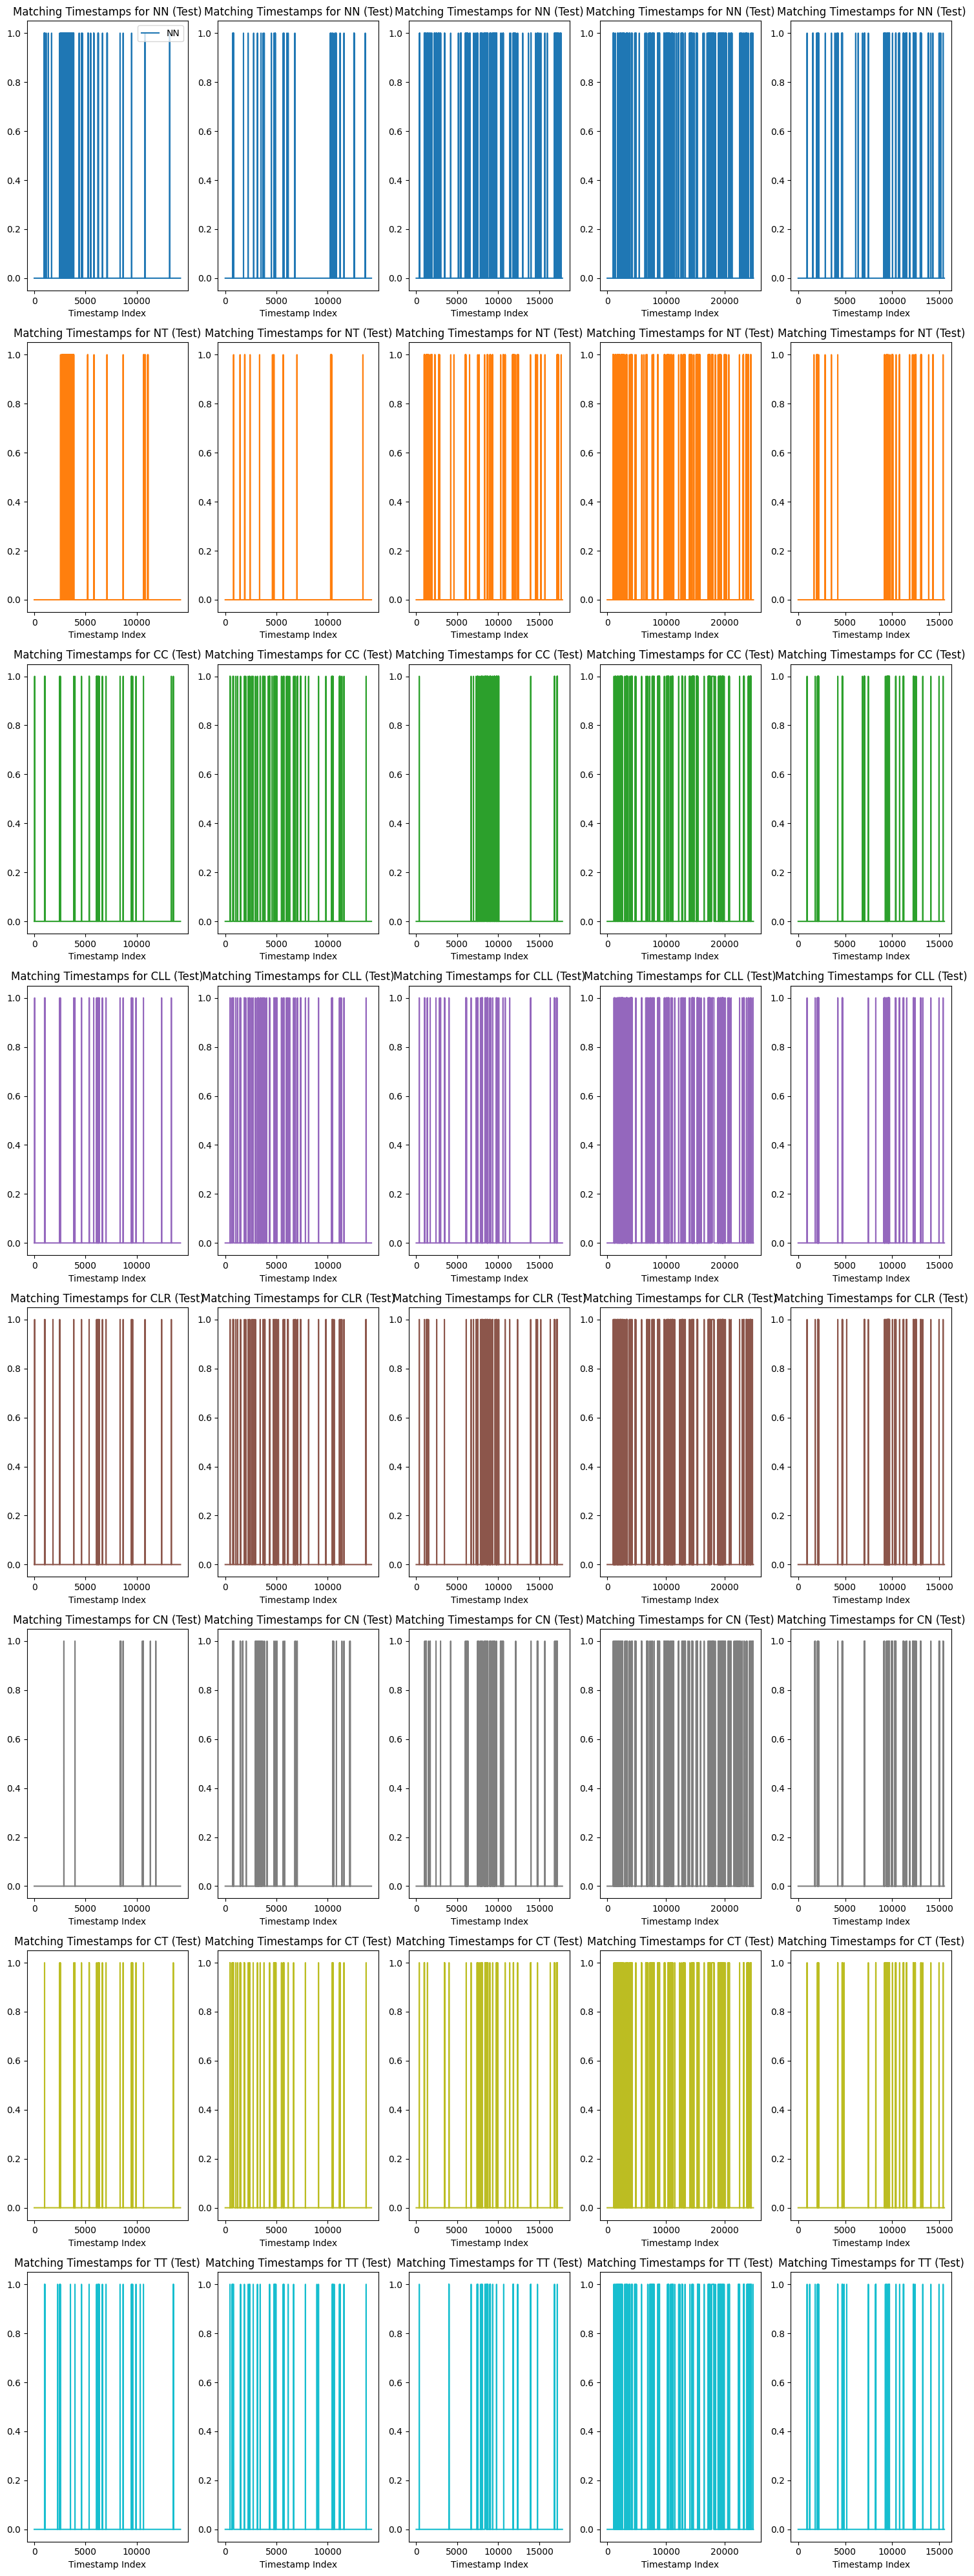

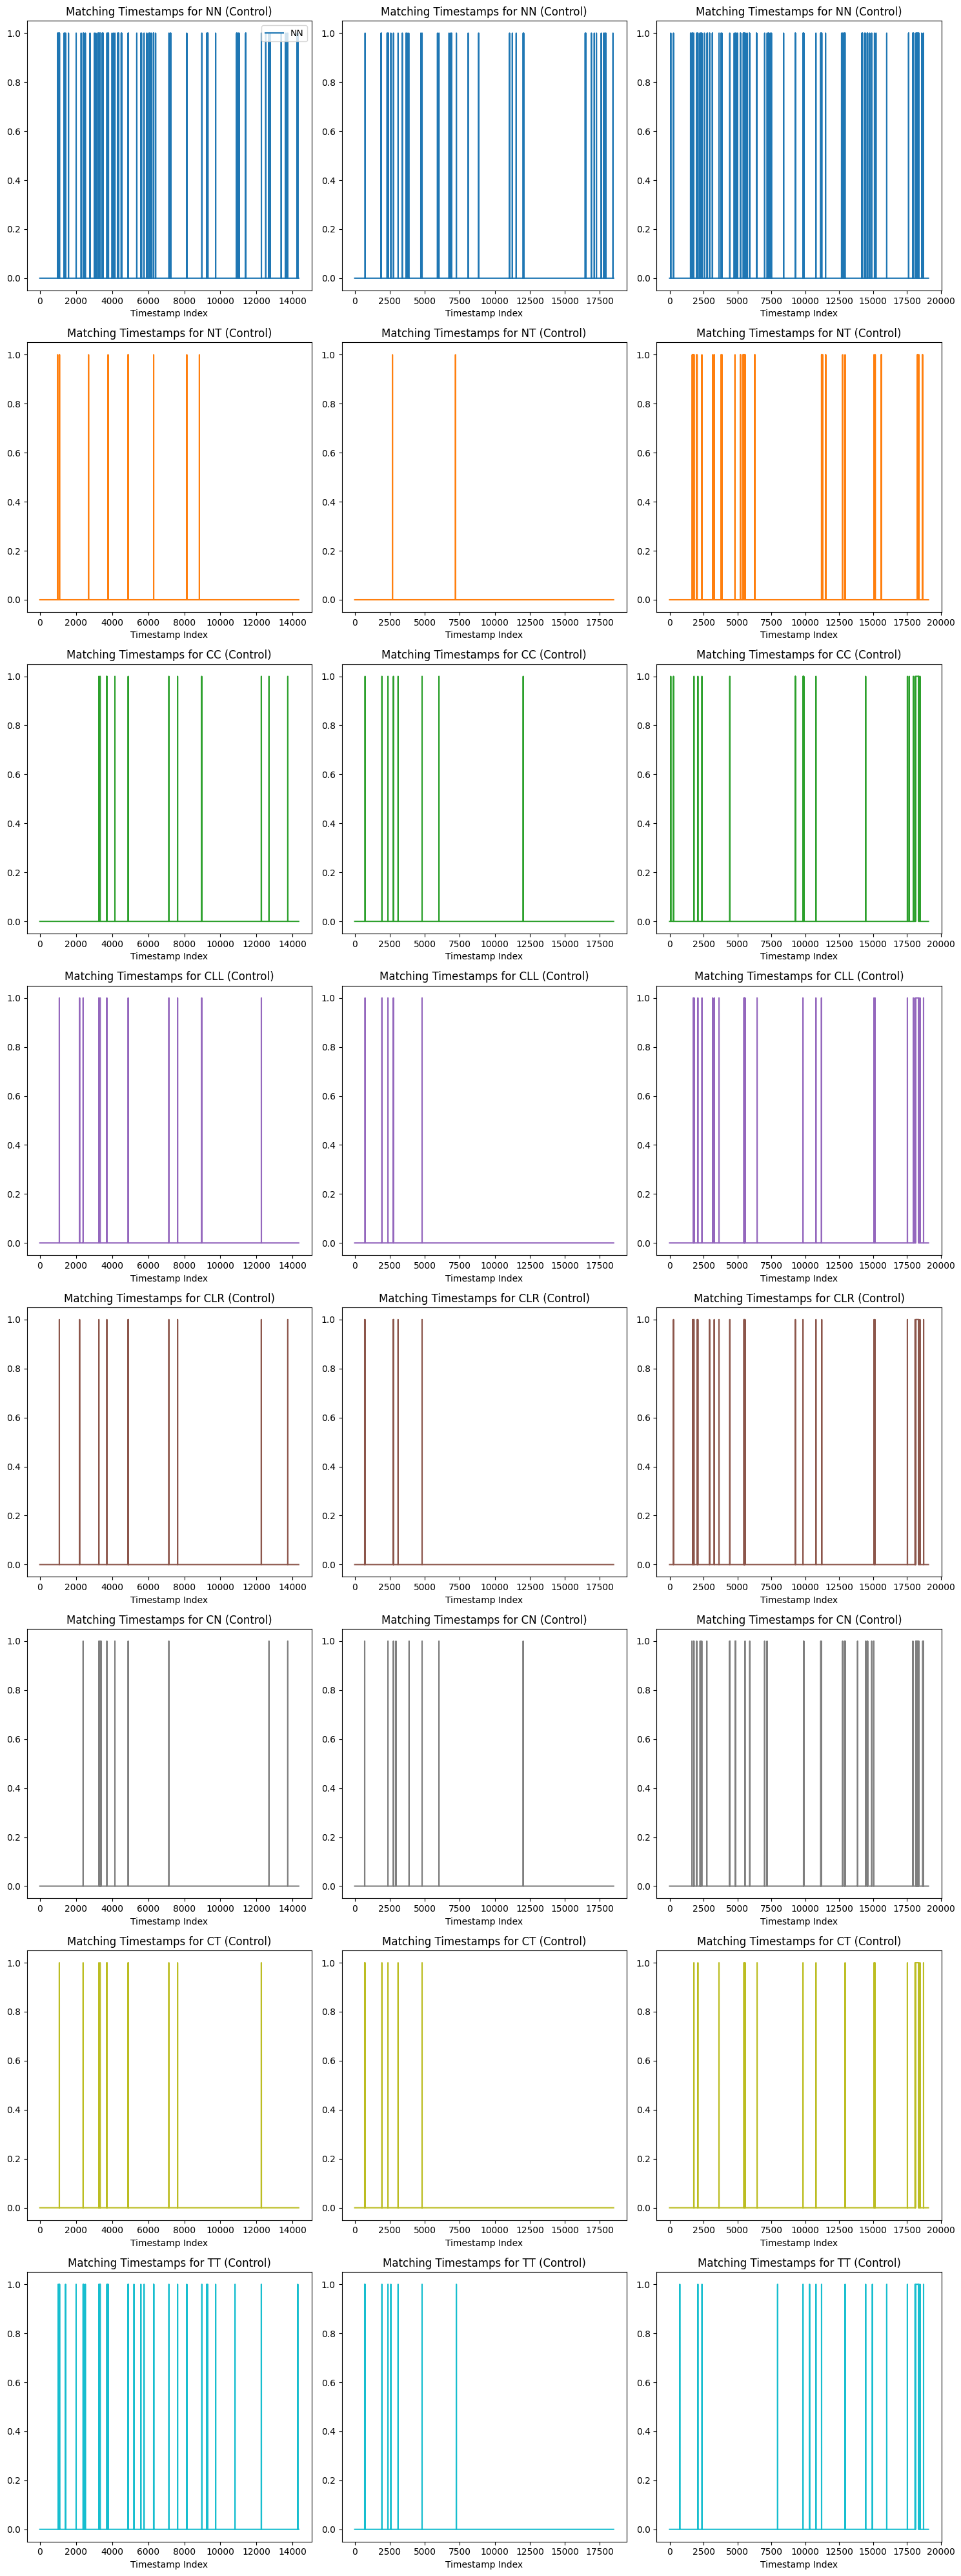

In [11]:
events = ['NN', 'NT', 'CC', 'CLL', 'CLR', 'CN', 'CT', 'TT']
#events = ['CN', 'CT']
visualize = True

# Define a color cycle for each event type
color_cycle = plt.cm.get_cmap('tab10', len(events))

# Visualize test data
fig, axes = plt.subplots(nrows=len(events), ncols=len(test_ids), figsize=(15, 5 * len(events)))

if visualize:
    for test_index, test_id in enumerate(test_ids):
        for event_index, event_type in enumerate(events):
            event = t_aligned_events[test_index][event_type]
            ax = axes[event_index, test_index]
            ax.set_title(f'Matching Timestamps for {event_type} (Test)')
            ax.set_xlabel('Timestamp Index')
            ax.plot(event, color=color_cycle(event_index), label=event_type)

            # Add a legend to the first subplot
            if test_index == 0 and event_index == 0:
                ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Visualize control data
fig, axes = plt.subplots(nrows=len(events), ncols=len(ctrl_ids), figsize=(15, 5 * len(events)))

if visualize:
    for ctrl_index, ctrl_id in enumerate(ctrl_ids):
        for event_index, event_type in enumerate(events):
            event = c_aligned_events[ctrl_index][event_type]
            ax = axes[event_index, ctrl_index]
            ax.set_title(f'Matching Timestamps for {event_type} (Control)')
            ax.set_xlabel('Timestamp Index')
            ax.plot(event, color=color_cycle(event_index), label=event_type)

            # Add a legend to the first subplot
            if ctrl_index == 0 and event_index == 0:
                ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Get total duration time (ms) of behavioral bout per animal

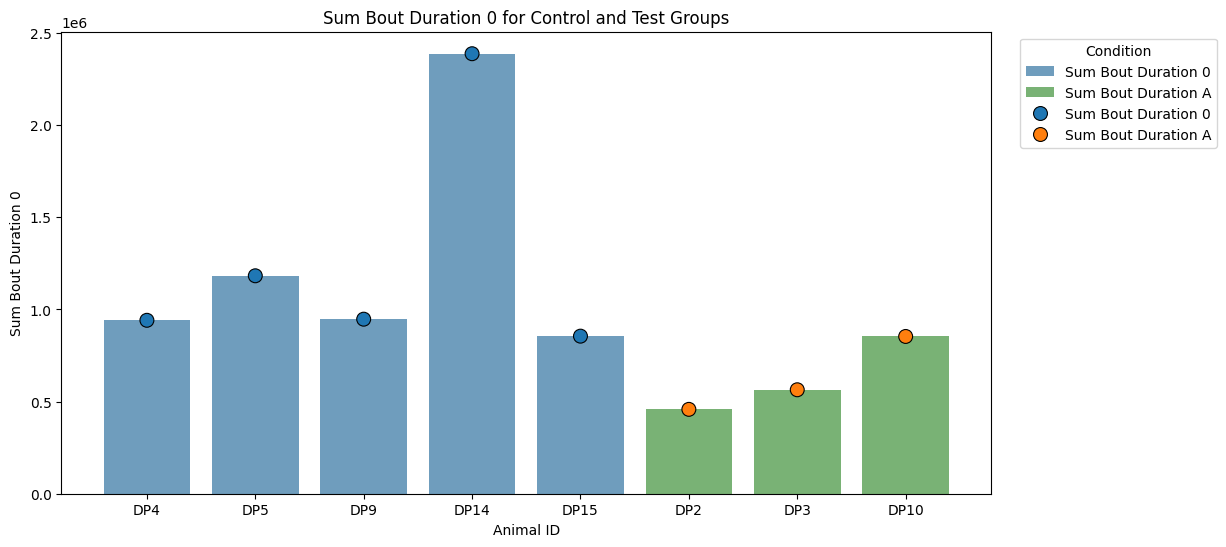

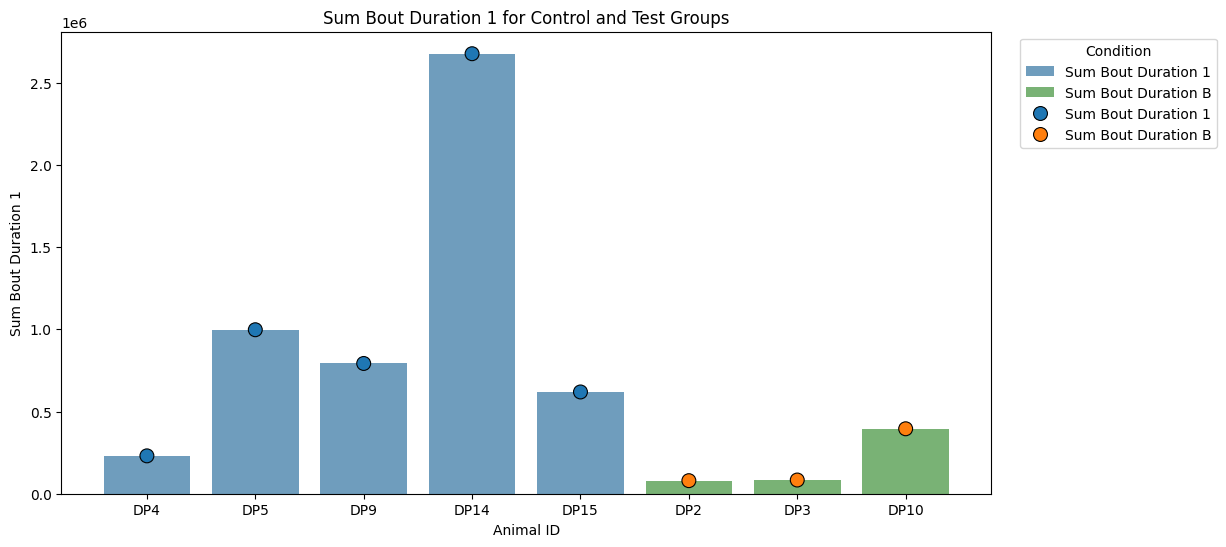

Control Group:
Animal ID	Sum Bout Duration 0	Sum Bout Duration 1
DP2		457952.00			79427.00
DP3		564252.00			83319.00
DP10		853624.00			395018.00
Test Group:
Animal ID	Sum Bout Duration 0	Sum Bout Duration 1
DP15		941402.00			230301.00
DP15		1182995.00			997368.00
DP15		947427.00			792243.00
DP15		2388389.00			2676178.00
DP15		855286.00			618963.00


In [12]:
event_type = 'CN'

index_list0c = {}
index_list1c = {}
ids=ctrl_ids
behavior_epochs=c_aligned_events
for id in ids:
    animal_index=npa.get_index(ids, id)
    event = behavior_epochs[animal_index][event_type]
    start_indices_zero, end_indices_zero = behav.index_binary_sequences(event, 0, 100, animal_index)
    start_indices_one, end_indices_one = behav.index_binary_sequences(event, 1, 100, animal_index)
    
    
    behav_timestamp_path = os.path.join(parent_path, str(id), 'all', 'behav', 'timeStamps.csv')
    img_timestamp_path = os.path.join(parent_path, str(id), 'all', 'img', 'timeStamps.csv')
    
    behav_timestamps_df = pd.read_csv(behav_timestamp_path)
    img_timestamps_df = pd.read_csv(img_timestamp_path)
    
    behav_merged_timestamps =behav_timestamps_df['merged_timestamps']
    img_merged_timestamps = img_timestamps_df['merged_timestamps']
    
    # Process sequences for 0 values
    start_idx0, end_idx0, start_time0, end_time0, bout0 = behav.process_sequences(event, (start_indices_zero, end_indices_zero), behav_merged_timestamps, img_merged_timestamps)
    start_idx1, end_idx1, start_time1, end_time1, bout1 = behav.process_sequences(event, (start_indices_one, end_indices_one), behav_merged_timestamps, img_merged_timestamps)
    index_list0c[id] = {'start idx': start_idx0, 'end idx': end_idx0, 'start time': start_time0, 'end time': end_time0, 'duration': bout0}
    index_list1c[id] = {'start idx': start_idx1, 'end idx': end_idx1, 'start time': start_time1, 'end time': end_time1, 'duration': bout1}


sum0c = []
sum1c = []
ids=ctrl_ids
for id in ids:
    animal_index=npa.get_index(ids, id)
    
    duration0 = index_list0c[id]['duration']
    duration1 = index_list1c[id]['duration']
    sum0c.append(np.sum(duration0))
    sum1c.append(np.sum(duration1))
    
index_list0t = {}
index_list1t = {}
ids=test_ids
behavior_epochs=t_aligned_events
for id in ids:
    animal_index=npa.get_index(ids, id)
    event = behavior_epochs[animal_index][event_type]
    start_indices_zero, end_indices_zero = behav.index_binary_sequences(event, 0, 100,animal_index)
    start_indices_one, end_indices_one = behav.index_binary_sequences(event, 1,100, animal_index)
    
    
    behav_timestamp_path = os.path.join(parent_path, str(id), 'all', 'behav', 'timeStamps.csv')
    img_timestamp_path = os.path.join(parent_path, str(id), 'all', 'img', 'timeStamps.csv')
    
    behav_timestamps_df = pd.read_csv(behav_timestamp_path)
    img_timestamps_df = pd.read_csv(img_timestamp_path)
    
    behav_merged_timestamps =behav_timestamps_df['merged_timestamps']
    img_merged_timestamps = img_timestamps_df['merged_timestamps']
    
    # Process sequences for 0 values
    start_idx0, end_idx0, start_time0, end_time0, bout0 = behav.process_sequences(event, (start_indices_zero, end_indices_zero), behav_merged_timestamps, img_merged_timestamps)
    start_idx1, end_idx1, start_time1, end_time1, bout1 = behav.process_sequences(event, (start_indices_one, end_indices_one), behav_merged_timestamps, img_merged_timestamps)
    index_list0t[id] = {'start idx': start_idx0, 'end idx': end_idx0, 'start time': start_time0, 'end time': end_time0, 'duration': bout0}
    index_list1t[id] = {'start idx': start_idx1, 'end idx': end_idx1, 'start time': start_time1, 'end time': end_time1, 'duration': bout1}
    

sum0t = []
sum1t = []
ids=test_ids
for id in ids:
    animal_index=npa.get_index(ids, id)
    
    duration0 = index_list0t[id]['duration']
    duration1 = index_list1t[id]['duration']
    sum0t.append(np.sum(duration0))
    sum1t.append(np.sum(duration1))
    
behav.plot_test_data(ctrl_ids, sum0c, sum1c, test_ids, sum0t, sum1t)

# Print results for control group
print("Control Group:")
print("Animal ID\tSum Bout Duration 0\tSum Bout Duration 1")
for ctrl_id, sum0c, sum1c in zip(ctrl_ids, sum0c, sum1c):
    print(f"{ctrl_id}\t\t{sum0c:.2f}\t\t\t{sum1c:.2f}")

# Print results for control group
print("Test Group:")
print("Animal ID\tSum Bout Duration 0\tSum Bout Duration 1")
for testl_id, sum0t, sum1t in zip(test_ids, sum0t, sum1t):
    print(f"{test_id}\t\t{sum0t:.2f}\t\t\t{sum1t:.2f}")


## Frequency (Hz) of events per behavioral epoch

In [13]:
# Example usage:
ids=ctrl_ids
bout_index=index_list0c
calcium_dataset=ctrl_deconvolved_datasets
#calcium_dataset=ctrl_datasets
condition = 'Non Interaction epochs'

Fctrl0={}
for id in ids:
    animal_index=npa.get_index(ids, id)
    calcium_traces = calcium_dataset[animal_id_index]
    start_list = bout_index[id]['start idx']
    end_list = bout_index[id]['end idx']
    f = behav.behavior_epoch_event_freq(calcium_traces, start_list, end_list, 2)
    #print(id, "Average Frequency:", condition, f['f avg bout'])  # Print the Favg value with label
    #print(id, "Trial Frequency:", f['f full trace'])  # Print the Favg value with label

    Fctrl0[id]={'freq': f}

bout_index=index_list1c
calcium_dataset=ctrl_deconvolved_datasets
#calcium_dataset=ctrl_datasets
condition = 'Interaction epochs'

Fctrl1={}
for id in ids:
    animal_index=npa.get_index(ids, id)
    calcium_traces = calcium_dataset[animal_id_index]
    start_list = bout_index[id]['start idx']
    end_list = bout_index[id]['end idx']
    f = behav.behavior_epoch_event_freq(calcium_traces, start_list, end_list, 2)
    #print(id, "Average Frequency:", condition, f['f avg bout'])  # Print the Favg value with label
    #print(id, "Trial Frequency:", f['f full trace'])  # Print the Favg value with label
    Fctrl1[id]={'freq': f}


ids=test_ids
bout_index=index_list0t
calcium_dataset=test_deconvolved_datasets
#calcium_dataset=test_datasets
condition= 'Non Interaction epochs'
full = 'Full trial'
Ftest0={}
for id in ids:

    animal_index=npa.get_index(ids, id)
    calcium_traces = calcium_dataset[animal_id_index]
    start_list = bout_index[id]['start idx']
    end_list = bout_index[id]['end idx']
    f = behav.behavior_epoch_event_freq(calcium_traces, start_list, end_list, 2)
    #print(id, "Average Frequency:", condition, f['f avg bout'])  # Print the Favg value with label
    #print(id, "Trial Frequency:", f['f full trace'])  # Print the Favg value with label
    Ftest0[id]={'freq': f}


bout_index=index_list1t
calcium_dataset=test_deconvolved_datasets
#calcium_dataset=test_datasets
condition= 'Interaction epochs'
full = 'Full trial'
Ftest1={}
for id in ids:

    animal_index=npa.get_index(ids, id)
    calcium_traces = calcium_dataset[animal_id_index]
    start_list = bout_index[id]['start idx']
    end_list = bout_index[id]['end idx']
    f = behav.behavior_epoch_event_freq(calcium_traces, start_list, end_list, 2)
    #print(id, "Average Frequency:", condition, f['f avg bout'])  # Print the Favg value with label
    #print(id, "Trial Frequency:", f['f full trace'])  # Print the Favg value with label
    Ftest1[id]={'freq': f}

# Print results for control group
print("Control Group:")
print("Animal ID\tNonInteraction(Hz)\tInteraction(Hz)")
for ctrl_id in ctrl_ids:
    id = npa.get_index(ctrl_ids, ctrl_id)
    print(f"{ctrl_id}\t\t{Fctrl0[ctrl_id]['freq']['f avg bout']}\t\t\t{Fctrl1[ctrl_id]['freq']['f avg bout']}")

# Print results for test group
print("Test Group:")
print("Animal ID\tNonInteraction(Hz)\tInteraction(Hz)")
for test_id in test_ids:
    print(f"{test_id}\t\t{Ftest0[test_id]['freq']['f avg bout']}\t\t\t{Ftest1[test_id]['freq']['f avg bout']}")


NameError: name 'animal_id_index' is not defined

## ROC (receiver operating characteristic) analysis

Animal ID: DP2
Percentage Not Significant: 90.3448275862069%
Percentage Excited: 5.517241379310345%
Percentage Inhibited: 4.137931034482759%
Animal ID: DP3
Percentage Not Significant: 96.55172413793103%
Percentage Excited: 2.2988505747126435%
Percentage Inhibited: 1.1494252873563218%
Animal ID: DP10
Percentage Not Significant: 92.5925925925926%
Percentage Excited: 7.4074074074074066%
Percentage Inhibited: 0.0%


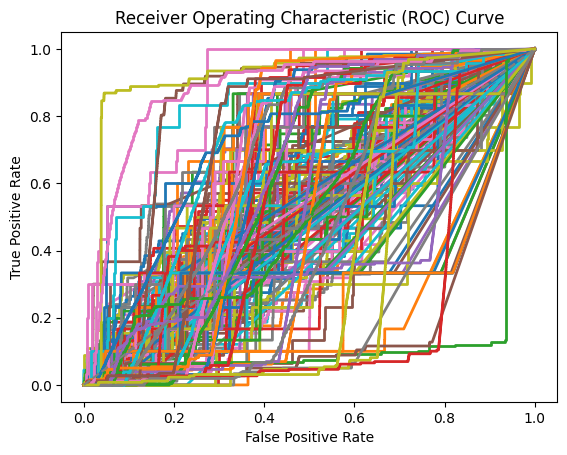

In [461]:
events = ['NN', 'NT', 'CC', 'CLL', 'CLR', 'CN', 'CT', 'TT']
#events = ['CN', 'CT']

ids=ctrl_ids
calcium_traces=ctrl_deconvolved_datasets
group = 'ctrl'
behavior_events=c_aligned_events
behavior_type_to_analyze='TT'
num_permutations=50
save_as = group + '_' + behavior_type_to_analyze + '_'+str(num_permutations) + '_auROC.pkl'

auROC_dataset = auROC.process_behavioral_events(ids, calcium_traces, behavior_events, behavior_type=behavior_type_to_analyze, num_permutations=num_permutations)
with open(save_as, 'wb') as file:
    pickle.dump(auROC_dataset, file)

In [4]:
ctrl_deconvolved_CN_behaviors = auROC.process_behavioral_events(ctrl_ids, ctrl_deconvolved_datasets, c_aligned_events, behavior_type='CN', num_permutations=500)
with open('all_behaviors_auROC_CN_deconvolved_ctrl.pkl', 'wb') as file:
    pickle.dump(ctrl_deconvolved_CN_behaviors, file)

print("all_behaviors has been saved to all_behaviors_auROC_CN_deconvolved_ctrl.pkl")

ctrl_deconvolved_CT_behaviors = auROC.process_behavioral_events(ctrl_ids, ctrl_deconvolved_datasets, c_aligned_events, behavior_type='CT', num_permutations=500)
with open('all_behaviors_auROC_CT_deconvolved_ctrl.pkl', 'wb') as file:
    pickle.dump(ctrl_deconvolved_CT_behaviors, file)

ctrl_raw_CN_behaviors = auROC.process_behavioral_events(ctrl_ids, ctrl_datasets, c_aligned_events, behavior_type='CN', num_permutations=500)
with open('all_behaviors_auROC_CN_raw_ctrl.pkl', 'wb') as file:
    pickle.dump(ctrl_raw_CN_behaviors, file)

print("all_behaviors has been saved to all_behaviors_auROC_CN_deconvolved_ctrl.pkl")

ctrl_raw_CT_behaviors = auROC.process_behavioral_events(ctrl_ids, ctrl_datasets, c_aligned_events, behavior_type='CT', num_permutations=500)
with open('all_behaviors_auROC_CT_raw_ctrl.pkl', 'wb') as file:
    pickle.dump(ctrl_raw_CT_behaviors, file)

NameError: name 'auROC' is not defined

In [14]:
with open('ctrl_TT_50_auROC.pkl', 'rb') as file:
    ctrl_auROC_loaded = pickle.load(file)
with open('test_TT_20_auROC.pkl', 'rb') as file:
    test_auROC_loaded= pickle.load(file)

In [15]:
ctrl_auROC=ctrl_auROC_loaded
test_auROC=test_auROC_loaded


all_percentage_inhibited_data_type='all_percentage_inhibited'
all_percentage_excited_data_type='all_percentage_excited'
all_percentage_not_significant_data_type='all_percentage_not_significant'


list_data_results = [
    'all_auc_values', 'all_inhibited_counts', 'all_excited_counts', 'all_not_significant_counts',
    'all_inhibited_cell_lists', 'all_excited_cell_lists', 'all_not_significant_cell_lists',
    'all_percentage_inhibited', 'all_percentage_excited', 'all_percentage_not_significant'
]

i_idx = npa.get_index(list_data_results, all_percentage_inhibited_data_type)
e_idx=npa.get_index(list_data_results, all_percentage_excited_data_type)
ns_idx=npa.get_index(list_data_results, all_percentage_not_significant_data_type)
I_idx=npa.get_index(list_data_results, 'all_inhibited_cell_lists')
E_idx=npa.get_index(list_data_results, 'all_excited_cell_lists')
NS_idx=npa.get_index(list_data_results, 'all_not_significant_cell_lists')



In [17]:
def get_index(list_items, list_item):
    return list_items.index(list_item) if list_item in list_items else -1

# Function to generate subplot for a given behavior type
def generate_subplot(behavior_type, events, all_behaviors, all_percentage_inhibited_index, 
                     all_percentage_excited_index, all_percentage_not_significant_index, animal_ids, stress_animals, non_stress_animals):
    behavior_index = get_index(events, behavior_type)

    #inhibited = all_behaviors[behavior_index][all_percentage_inhibited_index]
    #excited = all_behaviors[behavior_index][all_percentage_excited_index]
    #not_sig = all_behaviors[behavior_index][all_percentage_not_significant_index]
    inhibited=all_percentage_inhibited_index
    excited = all_percentage_excited_index

    # Initialize lists to store percentages for each category
    inhibited_stress = []
    excited_stress = []
    not_sig_stress = []

    inhibited_non_stress = []
    excited_non_stress = []
    not_sig_non_stress = []

    # Iterate through stress animals
    stress_index_ids = [animal_ids.index(animal) for animal in stress_animals]
    for stress_index_id in stress_index_ids:
        # Use lists to store percentages for each category
        inhibited_stress.append(inhibited[stress_index_id]/10)
        excited_stress.append(excited[stress_index_id]/10)
        not_sig_stress.append(not_sig[stress_index_id]/10)

    # Similarly, iterate through non-stress animals
    index_ids_non_stress = [animal_ids.index(animal) for animal in non_stress_animals]
    for index_id in index_ids_non_stress:
        # Use lists to store percentages for each category
        inhibited_non_stress.append(inhibited[index_id]/10)
        excited_non_stress.append(excited[index_id]/10)
        not_sig_non_stress.append(not_sig[index_id]/10)


    # Calculate averages for stress and non-stress animals
    average_inhibited_stress = np.mean(inhibited_stress, axis=0)
    average_excited_stress = np.mean(excited_stress, axis=0)
    average_not_significant_stress = np.mean(not_sig_stress, axis=0)

    average_inhibited_non_stress = np.mean(inhibited_non_stress, axis=0)
    average_excited_non_stress = np.mean(excited_non_stress, axis=0)
    average_not_significant_non_stress = np.mean(not_sig_non_stress, axis=0)

    # Calculate standard errors for error bars
    sem_inhibited_stress = np.std(inhibited_stress, axis=0) / np.sqrt(len(inhibited_stress))
    sem_excited_stress = np.std(excited_stress, axis=0) / np.sqrt(len(excited_stress))
    sem_not_significant_stress = np.std(not_sig_stress, axis=0) / np.sqrt(len(not_sig_stress))

    sem_inhibited_non_stress = np.std(inhibited_non_stress, axis=0) / np.sqrt(len(inhibited_non_stress))
    sem_excited_non_stress = np.std(excited_non_stress, axis=0) / np.sqrt(len(excited_non_stress))
    sem_not_significant_non_stress = np.std(not_sig_non_stress, axis=0) / np.sqrt(len(not_sig_non_stress))
    
    #Plotting
    labels = ['Non resp', 'Inhib', 'Excit', 'Non resp- stress', 'Inhib- stress', 'Excit - stress']
    fig, ax = plt.subplots(figsize=(2, 3))

    x_positions_non_resp_non_stress =1
    x_positions_inhib_non_stress =2
    x_positions_excit_non_stress =3
    x_positions_non_resp_stress =5
    x_positions_inhib_stress =6
    x_positions_excit_stress =7

    # x positions for bars
    x_positions = [x_positions_non_resp_non_stress, x_positions_inhib_non_stress, x_positions_excit_non_stress,
                   x_positions_non_resp_stress, x_positions_inhib_stress, x_positions_excit_stress]
    transparent_blues = [(0, 0, 1, alpha) for alpha in [0.3, 0.5, 0.7]]
    transparent_reds = [(1, 0, 0, alpha) for alpha in [0.3, 0.5, 0.7]]

    bar_colors_new = transparent_blues + transparent_reds


    # Combine data for all animals (stress and non-stress)
    bar_colors = [plt.cm.Blues(np.linspace(0.2, 0.8, 3)), plt.cm.Reds(np.linspace(0.2, 0.8, 3))]


    average_all = [average_not_significant_non_stress, average_inhibited_non_stress, average_excited_non_stress,
                   average_not_significant_stress, average_inhibited_stress, average_excited_stress]
    sem_all = [sem_not_significant_non_stress, sem_inhibited_non_stress, sem_excited_non_stress,
               sem_not_significant_stress, sem_inhibited_stress, sem_excited_stress]


    ax.bar(x_positions, average_all, yerr=sem_all, capsize=5, color=bar_colors_new, width=0.8)



    for y in range (len(not_sig_non_stress)):
        y_values = not_sig_stress[y]
        ax.scatter(x_positions_non_resp_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(inhibited_non_stress)):
        y_values = inhibited_stress[y]
        ax.scatter(x_positions_inhib_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(excited_non_stress)):
        y_values = excited_non_stress[y]
        ax.scatter(x_positions_excit_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')

    for y in range (len(not_sig_stress)):
        y_values = not_sig_stress[y]
        ax.scatter(x_positions_non_resp_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(inhibited_stress)):
        y_values = inhibited_stress[y]
        ax.scatter(x_positions_inhib_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(excited_stress)):
        y_values = excited_stress[y]
        ax.scatter(x_positions_excit_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')


    ax.set_xticks(x_positions)  # Set the x-axis ticks to the specified positions
    ax.set_xticklabels(labels)  # Set the labels for each x-axis tick
    ax.set_xlabel('Cell Types')
    ax.set_ylabel('Average Cell Percentages')
    ax.set_title('Average Distribution of Cell Types - All Animals')
    ax.set_ylim(0, 40)  # Set y-axis limits

    return ax, not_sig_non_stress, inhibited_non_stress, excited_non_stress, not_sig_stress, inhibited_stress, excited_stress  # Return the subplot axis


# Assuming the function generate_subplot is already defined

# Data for non-stress condition
non_stress_inhibited = [4.137931034, 10.34482759, 8.045977011]
non_stress_excited = [5.517241379, 17.93103448, 10.34482759]

# Data for stress condition
stress_inhibited = [6.25, 7.407407407, 12.5, 5.128205128]
stress_excited = [4.166666667, 11.11111111, 11.53846154, 10.25641026]

# Additional information (you need to replace these with your actual data)
behavior_type = "Interaction"
events = "Interaction"
all_percentage_inhibited_index = [4.137931034, 10.34482759, 8.045977011]
all_percentage_excited_index = [5.517241379, 17.93103448, 10.34482759]
all_percentage_not_significant_index = [6.25, 7.407407407, 12.5, 5.128205128]
animal_ids = test_ids
stress_animals = test_ids
non_stress_animals = ctrl_ids

# Generate the subplot
ax, _, _, _, _, _, _ = generate_subplot(behavior_type, events, all_behaviors, all_percentage_inhibited_index,
                                        all_percentage_excited_index, all_percentage_not_significant_index,
                                        animal_ids, stress_animals, non_stress_animals)

# Plot the data for non-stress condition
ax.scatter([1]*len(non_stress_inhibited), non_stress_inhibited, color='black', alpha=0.5, s=20, label='_nolegend_')
ax.scatter([2]*len(non_stress_excited), non_stress_excited, color='black', alpha=0.5, s=20, label='_nolegend_')

# Plot the data for stress condition
ax.scatter([5]*len(stress_inhibited), stress_inhibited, color='black', alpha=0.5, s=20, label='_nolegend_')
ax.scatter([6]*len(stress_excited), stress_excited, color='black', alpha=0.5, s=20, label='_nolegend_')

# Show the plot
plt.show()


NameError: name 'all_behaviors' is not defined


Statistical Analysis:
T-test p-value for Group1 vs Group2: 0.405472829126735
T-test p-value for Group1 vs Group3: 0.9037084097318715
T-test p-value for Group1 vs Group4: 0.5193563867341073
T-test p-value for Group2 vs Group1: 0.405472829126735
T-test p-value for Group2 vs Group3: 0.38085297297066223
T-test p-value for Group2 vs Group4: 0.6074655621655959
T-test p-value for Group3 vs Group1: 0.9037084097318715
T-test p-value for Group3 vs Group2: 0.38085297297066223
T-test p-value for Group3 vs Group4: 0.5637694382719144
T-test p-value for Group4 vs Group1: 0.5193563867341073
T-test p-value for Group4 vs Group2: 0.6074655621655959
T-test p-value for Group4 vs Group3: 0.5637694382719144


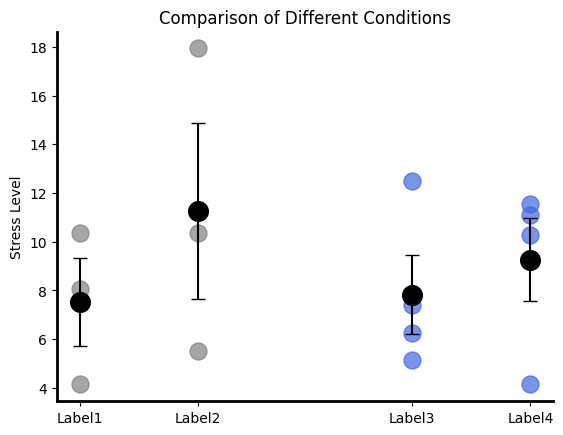

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_and_compare(data, group_labels=None):
    # Plotting individual data points
    groups = list(data.keys())
    num_groups = len(groups)

    # Define x-coordinates based on the clustering
    x_coordinates = []
    for i, group_name in enumerate(groups, start=1):
        if group_name.startswith('Group1') or group_name.startswith('Group2'):
            x_coordinates.append(i - 0.4)
        else:
            x_coordinates.append(i + 0.4)

    for x, group_name in zip(x_coordinates, groups):
        color = 'gray' if group_name.startswith('Group1') or group_name.startswith('Group2') else 'royalblue'
        marker_size = 150  # Larger scatter points
        alpha = 0.7  # Adjust transparency

        plt.scatter(x * np.ones_like(data[group_name]), data[group_name], color=color,
                    s=marker_size, alpha=alpha)

    # Plotting the average with standard errors of the mean
    averages = [np.mean(data[group]) for group in groups]
    sems = [stats.sem(data[group]) for group in groups]

    avg_color = 'black'
    avg_marker_size = 200  # Larger average scatter points

    plt.scatter(x_coordinates, averages, marker='o', color=avg_color, s=avg_marker_size)
    plt.errorbar(x_coordinates, averages, yerr=sems, linestyle='', color=avg_color, capsize=5)

    # Plotting settings
    if group_labels is None:
        group_labels = groups
    plt.xticks(x_coordinates, group_labels)
    plt.ylabel('Stress Level')
    plt.title('Comparison of Different Conditions')

    # Remove border and keep only x and y-axis
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    # Running statistical analysis
    p_values = {}

    for group1 in groups:
        for group2 in groups:
            if group1 != group2:
                _, p_value = stats.ttest_ind(data[group1], data[group2])
                comparison_label = f"{group1} vs {group2}"
                p_values[comparison_label] = p_value

    print("\nStatistical Analysis:")
    for comparison_label, p_value in p_values.items():
        print(f"T-test p-value for {comparison_label}: {p_value}")

    # Show plot without legend
    plt.show()

# Example data with multiple groups
data = {
    'Group1': [4.137931034, 10.34482759, 8.045977011],
    'Group2': [5.517241379, 17.93103448, 10.34482759],
    'Group3': [6.25, 7.407407407, 12.5, 5.128205128],
    'Group4': [4.166666667, 11.11111111, 11.53846154, 10.25641026]
}

# Custom group labels (optional)
group_labels = ['Label1', 'Label2', 'Label3', 'Label4']

# Call the function with the provided data and custom labels
plot_and_compare(data, group_labels)


<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:4: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Samara\AppData\Local\Temp\ipykernel_19656\1955035669.py:4: SyntaxWarning: invalid escape sequence '\R'
  folder='H:\Reed-Behaviors'


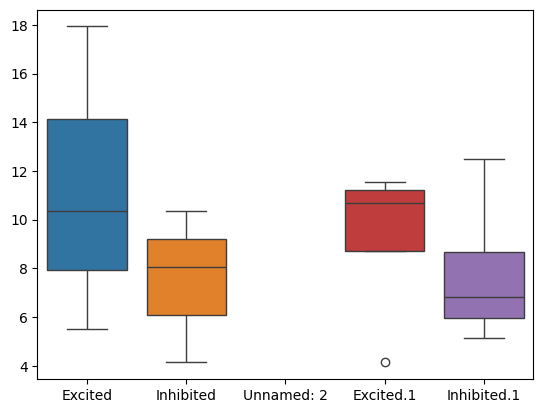

     Excited  Inhibited  Unnamed: 2  Excited.1  Inhibited.1
0   5.517241   4.137931         NaN   4.166667     6.250000
1  17.931034  10.344828         NaN  11.111111     7.407407
2  10.344828   8.045977         NaN  11.538462    12.500000
3        NaN        NaN         NaN  10.256410     5.128205


In [19]:
import pandas as pand
from matplotlib import pyplot as plt
import seaborn as sns
folder='H:\Reed-Behaviors'
data_type ='percent_opp'
file='data - ' + data_type + '.csv'
scores = pand.read_csv(os.path.join(folder,file), encoding='unicode_escape')
sns.boxplot(data=scores)
plt.show()
print(scores)

## Extract activity around start or end of interaction (for plotting purposes)

In [44]:

    
def plot_activity_for_neuron_index_no_save(extracted_activity, neuron_indices, title, before_window, after_window):
    num_neurons, num_behav_bouts, max_length = extracted_activity.shape

    # Determine the number of rows and columns for the grid
    num_plots = len(neuron_indices)
    num_cols = min(num_plots, 3)  # You can adjust the number of columns as needed
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    # Loop over provided neuron indices
    for idx, neuron_id in enumerate(neuron_indices, start=1):
        if neuron_id < 0 or neuron_id >= num_neurons:
            print(f"Invalid neuron index: {neuron_id}. Skipping.")
            continue

        # Compute mean and standard deviation for the current neuron
        mean_activity = np.mean(extracted_activity[neuron_id], axis=0)
        individual_std_activity = np.std(extracted_activity[neuron_id], axis=0)
        sample_size = num_behav_bouts
        sem = individual_std_activity / np.sqrt(sample_size)

        # Specify color with lower alpha for transparency
        color = plt.cm.viridis(neuron_id / num_neurons)  # Adjust the colormap as needed
        color_with_transparency = (*color[:-1], 0.1)  # Set alpha to 0.2 for transparency

        # Create subplots in a grid
        plt.subplot(num_rows, num_cols, idx)

        

        # Plot error bars
        plt.errorbar(
            np.arange(-max_length // 2, max_length // 2),
            mean_activity,
            yerr=sem,
            color=color_with_transparency,  # Use the color with transparency for error bars

        )

        # Plot mean activity as a thinner black line
        plt.plot(
            np.arange(-max_length // 2, max_length // 2),
            mean_activity,
            color='gray',  # Set the color to black
            linewidth=0.8,  # Adjust the linewidth as needed
            label=title
        )

        plt.xlabel('Interaction onset')
        plt.ylabel('Mean Neuron Activity')
        plt.title(f'Neuron {neuron_id + 1}')  # Add neuron ID to the title
        plt.xticks([-before_window, 0, after_window], [-before_window, 0, after_window])  # Set x-axis labels

    # Adjust layout for better spacing
    plt.tight_layout()
  
    plt.show()



def plot_activity_for_neuron_index(extracted_activity, neuron_indices, title, before_window, after_window):
    num_neurons, num_behav_bouts, max_length = extracted_activity.shape

    # Determine the number of rows and columns for the grid
    num_plots = len(neuron_indices)
    num_cols = min(num_plots, 3)  # You can adjust the number of columns as needed
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Loop over provided neuron indices
    for idx, neuron_id in enumerate(neuron_indices, start=1):
        if neuron_id < 0 or neuron_id >= num_neurons:
            print(f"Invalid neuron index: {neuron_id}. Skipping.")
            continue

        # Compute mean and standard deviation for the current neuron
        mean_activity = np.mean(extracted_activity[neuron_id], axis=0)
        individual_std_activity = np.std(extracted_activity[neuron_id], axis=0)
        sample_size = num_behav_bouts
        sem = individual_std_activity / np.sqrt(sample_size)

        # Specify color with lower alpha for transparency
        color = plt.cm.viridis(neuron_id / num_neurons)  # Adjust the colormap as needed
        color_with_transparency = (*color[:-1], 0.1)  # Set alpha to 0.2 for transparency

        # Create subplots in a grid
        plt.subplot(num_rows, num_cols, idx)

        

        # Plot error bars
        plt.errorbar(
            np.arange(-max_length // 2, max_length // 2),
            mean_activity,
            yerr=sem,
            color=color_with_transparency,  # Use the color with transparency for error bars

        )

        # Plot mean activity as a thinner black line
        plt.plot(
            np.arange(-max_length // 2, max_length // 2),
            mean_activity,
            color='gray',  # Set the color to black
            linewidth=0.8,  # Adjust the linewidth as needed
            label=title
        )

        plt.xlabel('Interaction onset')
        plt.ylabel('Mean Neuron Activity')
        plt.title(f'Neuron {neuron_id + 1}')  # Add neuron ID to the title
        plt.xticks([-before_window, 0, after_window], [-before_window, 0, after_window])  # Set x-axis labels

    # Adjust layout for better spacing
    plt.tight_layout()
    output_file= "Z:\\DPC HONGWEI COLAB\\Example traces\\"+title+".svg"
    # Save the plot as an SVG file
    plt.savefig(output_file, format='svg')

    # Show the plots
    plt.show()


save_file=False
file_num="17"
#data_to_plot=excited
animal_id_index=4
animal_id=test_ids[animal_id_index]
title_start=animal_id + "_start_" + file_num
title_end=animal_id + "_end_" + file_num
behavior_type = 'CN'
behavior_datasets=t_aligned_events
behavior = behavior_datasets[animal_id_index][behavior_type]
neuron_activity=test_deconvolved_datasets[animal_id_index]
auROC_data=test_auROC
behavior_types = ['NN', 'NT', 'CC', 'CLL', 'CLR', 'CN', 'CT', 'TT']

#behavior_bouts = [behavior_datasets[event] for behavior_datasets in behavior_datasets]
timestamp_path = os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
behavior_bouts = npa.start_and_stop_behavior_events(behavior, timestamp_path)
b_idx=npa.get_index(behavior_types, behavior_type)

inhibited = auROC_data[I_idx]
excited =  auROC_data[E_idx]
not_sig =  auROC_data[NS_idx]

before_window=90
after_window=180
data_to_plot=excited
activity_during_events_start = npa.extract_activity_around_event_position_data(neuron_activity, timestamp_path, behavior_bouts, before_window, after_window, onset='start')
activity_during_events_end= npa.extract_activity_around_event_position_data(neuron_activity, timestamp_path, behavior_bouts, before_window, after_window, onset='stop')

#Plotting

cell_list = data_to_plot[animal_id_index]
if save_file:
    plot_activity_for_neuron_index(activity_during_events_start, cell_list[0], title=title_start, before_window=before_window, after_window=after_window)
    plot_activity_for_neuron_index(activity_during_events_end, cell_list[0],  title=title_end,  before_window=before_window, after_window=after_window)
else:
    plot_activity_for_neuron_index_no_save(activity_during_events_start, cell_list[0], title=title_start, before_window=before_window, after_window=after_window)
    plot_activity_for_neuron_index_no_save(activity_during_events_end, cell_list[0], title=title_end, before_window=before_window, after_window=after_window)

    

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

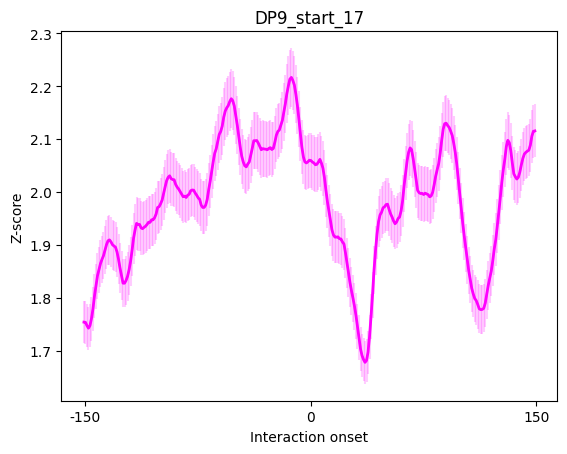

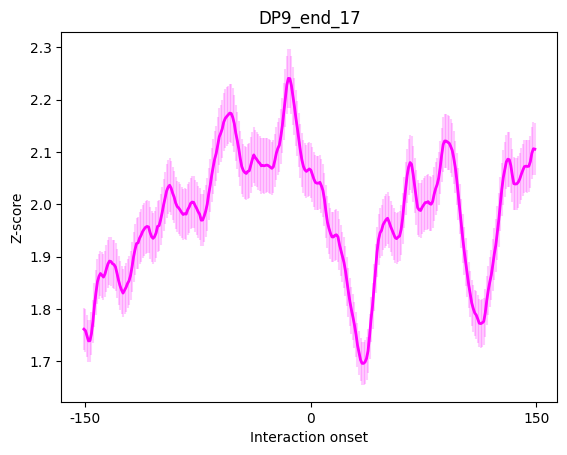

In [131]:
from matplotlib import colors as mcolors

    
def plot_average_activity_no_save(extracted_activity, title, before_window, after_window):
    num_neurons, num_behav_bouts, max_length = extracted_activity.shape
    
    m = []
    s = []
    
    # Loop over neuron indices
    for neuron_id in range(num_neurons):
        # Compute mean and standard deviation for the current neuron
        mean_activity = np.mean(extracted_activity[neuron_id], axis=0)
        individual_std_activity = np.std(extracted_activity[neuron_id], axis=0)
        sample_size = num_behav_bouts
        sem = individual_std_activity / (np.sqrt(sample_size)*3)
        m.append(mean_activity)
        s.append(sem)
    
    # Calculate the x-axis values (assuming there is some x-axis variable, adjust as needed)
    x_values = np.arange(-max_length // 2, max_length // 2)
    
    # Convert 'm' and 's' to NumPy arrays for easier manipulation
    m = np.array(m)
    s = np.array(s)
    
    # Calculate the mean and standard error across all neurons
    overall_mean = np.mean(m, axis=0)
    overall_sem = np.mean(s, axis=0)
    
    # Specify color with lower alpha for transparency
    color = plt.cm.viridis(0.5)  # Adjust the colormap as needed
    color_with_transparency = (*color[:-1], 0.1)  # Set alpha to 0.1 for transparency
    
    # Plot error bars
    plt.errorbar(
        x_values,
        overall_mean,
        yerr=overall_sem,
        color=color_with_transparency,  # Use the color with transparency for error bars
        label='Average Activity'
    )
    
    # Plot mean activity as a thinner black line
    plt.plot(
        x_values,
        overall_mean,
        color='gray',  # Set the color to black
        linewidth=0.8,  # Adjust the linewidth as needed
    )
    
    plt.xlabel('Interaction onset')
    plt.ylabel('Z-score')
    plt.title(title)  # Add neuron ID to the title
    plt.xticks([-before_window, 0, after_window], [-before_window, 0, after_window])  # Set x-axis labels
# Customize the plot as needed (legend, grid, etc.)
    
    plt.grid(False)
    
    # Show the plot
    plt.show()
# Rest of your code remains unchanged...



def plot_average_activity(extracted_activity, title, before_window, after_window):
    num_neurons, num_behav_bouts, max_length = extracted_activity.shape
    
    m = []
    s = []
    
    # Loop over neuron indices
    for neuron_id in range(num_neurons):
        # Compute mean and standard deviation for the current neuron
        mean_activity = np.mean(extracted_activity[neuron_id], axis=0)
        individual_std_activity = np.std(extracted_activity[neuron_id], axis=0)
        sample_size = num_behav_bouts
        sem = individual_std_activity / (np.sqrt(sample_size) * 10)
        m.append(mean_activity)
        s.append(sem)
    
    # Calculate the x-axis values (assuming there is some x-axis variable, adjust as needed)
    x_values = np.arange(-max_length // 2, max_length // 2)
    
    # Convert 'm' and 's' to NumPy arrays for easier manipulation
    m = np.array(m)
    s = np.array(s)
    
    # Calculate the mean and standard error across all neurons
    overall_mean = np.mean(m, axis=0)
    overall_sem = np.mean(s, axis=0)
    
    # Specify color with lower alpha for transparency
    color = 'magenta'  # Adjust the colormap as needed
    color_with_transparency =color_with_transparency = (*mcolors.to_rgba(color)[:-1], 0.2)

    
    # Plot error bars with transparent pink color
    plt.errorbar(
        x_values,
        overall_mean,
        yerr=overall_sem,
        color=color_with_transparency,  # Use the color with transparency for error bars
        label='Average Activity'
    )
    
    # Plot mean activity as a pink line
    plt.plot(
        x_values,
        overall_mean,
        color=color,  # Set the color to pink
        linewidth=2.0,  # Adjust the linewidth as needed
    )
    
    plt.xlabel('Interaction onset')
    plt.ylabel('Z-score')
    plt.title(title)  # Add neuron ID to the title
    plt.xticks([-before_window, 0, after_window], [-before_window, 0, after_window])  # Set x-axis labels
    
    # Customize the plot as needed (legend, grid, etc.)
    plt.grid(False)
    

    # Save the plot as an SVG file
    output_file = "Z:\\DPC HONGWEI COLAB\\Example traces\\" + title + ".svg"
    plt.savefig(output_file, format='svg')
    
    # Show the plot
    plt.show()

# Example usage:
# plot_average_activity(extracted_activity, "Example Title", before_window_value, after_window_value)

        

        

       


save_file=True
title_start=animal_id + "_start_" + file_num
title_end=animal_id + "_end_" + file_num
group_ctrl=False
animal_id_index=2
behavior_type = 'CN'

if group_ctrl:
    animal_id=ctrl_ids[animal_id_index]
    behavior_datasets=c_aligned_events
    neuron_activity=ctrl_deconvolved_datasets[animal_id_index]
    auROC_data=ctrl_auROC
else:   
    animal_id=test_ids[animal_id_index]
    behavior_datasets=t_aligned_events
    neuron_activity=test_deconvolved_datasets[animal_id_index]
    auROC_data=test_auROC

behavior = behavior_datasets[animal_id_index][behavior_type]
behavior_types = ['NN', 'NT', 'CC', 'CLL', 'CLR', 'CN', 'CT', 'TT']
timestamp_path = os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
behavior_bouts = npa.start_and_stop_behavior_events(behavior, timestamp_path)
b_idx=npa.get_index(behavior_types, behavior_type)
before_window=150
after_window=150

activity_during_events_start = npa.extract_activity_around_event_position_data(neuron_activity, timestamp_path, behavior_bouts, before_window, after_window, onset='start')
activity_during_events_end= npa.extract_activity_around_event_position_data(neuron_activity, timestamp_path, behavior_bouts, before_window, after_window, onset='stop')

if save_file:
    plot_average_activity(activity_during_events_start, title=title_start, before_window=before_window, after_window=after_window)
    plot_average_activity(activity_during_events_end,  title=title_end, before_window=before_window, after_window=after_window)
else:
    plot_average_activity_no_save(activity_during_events_start, title=title_start, before_window=before_window, after_window=after_window)
    plot_average_activity_no_save(activity_during_events_end, title=title_end, before_window=before_window, after_window=after_window)

    

In [54]:
print(len(m))

NameError: name 'm' is not defined

In [ ]:
categories_reordered = [
    "OPP ctrl freq", "SS ctrl freq", "OBJ ctrl freq",
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data_reordered = [
    [0.05750809842, 0.04238767291, 0.04388509202],
    [0.0541, 0.0468, 0.0431],
    [0.0377, 0.0431, 0.02975],
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0193, 0.0431, 0.0559, 0.032]
]

data = {
    "OPP ctrl inter": [0.05750809842, 0.04238767291, 0.04388509202],
    "SS ctrl inter": [0.0541, 0.0468, 0.0431],
    "OBJ ctrl inter": [0.03725, 0.0424, 0.02625],
    "OPP stress inter": [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    "SS stress inter": [0.0382, 0.0549, 0.0903, 0.0442],
    "OBJ inter": [0.02005, 0.04385, 0.0561, 0.0298],
    "OPP ctrl non": [0.04799430568, 0.03354884803, 0.02755414292],
    "SS ctrl non": [0.0492, 0.0577, 0.0398],
    "OPP stress non": [0.05459450159, 0.04715059589, 0.07329311048, 0.04728079108],
    "SS stress non": [0.0271, 0.0541, 0.0774, 0.036]
}
0.0377, 0.0431, 0.0297
0.0193, 0.0431, 0.0559, 0.032

data = {
    "OPP ctrl freq": [0.05750809842, 0.04238767291, 0.04388509202],
    "SS ctrl freq": [0.0541, 0.0468, 0.0431],
    "OBJ ctrl freq": [0.0377, 0.0431, 0.02975],
    "OPP stress freq": [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    "SS stress freq": [0.0382, 0.0549, 0.0903, 0.0442],
    "OBJ stress freq": [0.0193, 0.0431, 0.0559, 0.032]
}
categories = ["opp ctrl ratio E", "ss ctrl ratio E", "opp stress ratio E", "ss stress ratio E", "object ctrl ratio E", "object stress ratio E",
              "opp ctrl ratio I", "ss ctrl ratio I", "opp stress ratio I", "ss stress ratio I", "object ctrl ratio I", "object stress ratio I"]

data = [
    [0.5714285714, 0.6341463415, 0.5625],
    [0.6486486486, 0.4814814817, 0.7142857139],
    [0.4, 0.6, 0.48, 0.6666666667],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    [0.7142857143, 0.5769230761, 0.5624999994],
    [0.8181818179, 0.6363636366, 0.7999999995],
    [0.4285714286, 0.3658536585, 0.4375],
    [0.3513513514, 0.5185185183, 0.2857142861, 0.5555555556],
    [0.6, 0.4, 0.52],
    [0.2105263166, 0.5789473689, 0.3636363632, 0.4444444444],
    [0.2857142857, 0.4230769239, 0.4375000006, 0.3333333333],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.3333333333]
]

categories = ["opp ctrl ratio E", "ss ctrl ratio E", "opp stress ratio E", "ss stress ratio E", "object ctrl ratio E", "object stress ratio E",
              "opp ctrl ratio I", "ss ctrl ratio I", "opp stress ratio I", "ss stress ratio I", "object ctrl ratio I", "object stress ratio I"]

data = [
    [0.5714285714, 0.6341463415, 0.5625],
    [0.6486486486, 0.4814814817, 0.7142857139],
    [0.4, 0.6, 0.48, 0.6666666667],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    [0.7142857143, 0.5769230761, 0.5624999994],
    [0.8181818179, 0.6363636366, 0.7999999995],
    [0.4285714286, 0.3658536585, 0.4375],
    [0.3513513514, 0.5185185183, 0.2857142861, 0.5555555556],
    [0.6, 0.4, 0.52],
    [0.2105263166, 0.5789473689, 0.3636363632, 0.4444444444],
    [0.2857142857, 0.4230769239, 0.4375000006, 0.3333333333],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.3333333333]
]

categories = [
    "OPP ctrl freq", "SS ctrl freq", "OBJ ctrl freq",
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data = [
    [0.05750809842, 0.04238767291, 0.04388509202],
    [0.0541, 0.0468, 0.0431],
    [0.0377, 0.0431, 0.02975],
    [0.06409448191, 0.05381633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0193, 0.0431, 0.0559, 0.032]
]


categories = [
    "opp ctrl ratio E", "opp ctrl ratio I",
    "ss ctrl ratio E", "ss ctrl ratio I",
    "object ctrl ratio E", "object ctrl ratio I",
    "opp stress ratio E", "opp stress ratio I",
    "ss stress ratio E", "ss stress ratio I",
    "object stress ratio E", "object stress ratio I"
]


data = [
    [0.5714285714, 0.6341463415, 0.5625],
    [0.4285714286, 0.3658536585, 0.4375],
    [0.6486486486, 0.4814814817, 0.7142857139],
    [0.3513513514, 0.5185185183, 0.2857142861],
    [0.7142857143, 0.5769230761, 0.5624999994],
    [0.2857142857, 0.4230769239, 0.4375000006],
    [0.4, 0.6, 0.48, 0.6666666667],
    [0.6, 0.4, 0.52, 0.3333333333],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    [0.2105263166, 0.5789473689, 0.3636363632, 0.3333333333],
    [0.8181818179, 0.6363636366, 0.7999999995, 0.5555555556],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.4444444444]
]

categories = [
    "opp ctrl % E", "opp ctrl % I",
    "ss ctrl % E", "ss ctrl % I",
    "object ctrl % E", "object ctrl % I",
    "opp stress % E", "opp stress % I",
    "ss stress % E", "ss stress % I",
    "object stress % E", "object stress % I"
]
data = [
    [5.517241379, 17.93103448, 10.34482759],
    [4.137931034, 10.15625, 8.045977011],
    [18.75, 17.8082192, 13.6986301],
    [10.34482759, 19.1780822, 15.0684932],
    [11.71875, 20.5479452, 12.3287671],
    [4.6875, 15.0684932, 9.5890411],
    [4.166666667, 11.11111111, 11.53846154, 10.25641026],
    [6.25, 7.407407407, 12.5, 5.128205128],
    [10.2040816, 9.41176471, 24.137931, 4.04040404],
    [2.72108844, 12.9411765, 13.7931034, 2.02020202],
    [6.12244898, 8.23529412, 13.7931034, 5.05050505],
    [1.36054422, 4.70588235, 3.44827586, 4.04040404],
]



categories = [
    "OPP ctrl EI", "SS ctrl EI", "OBJ ctrl EI",
    "OPP stress EI", "SS stress EI", "OBJ stress EI"
]
data = [
    [1.333333333, 1.733333333, 1.285714286],
    [1.846153846, 0.9285714293, 2.499999995],
    [2.5, 1.363636359, 1.285714283],
    [0.6666666667, 1.5, 0.9230769231, 2],
    [3.749999982, 0.7272727259, 1.750000004, 2],
    [4.499999993, 1.750000002, 3.999999988, 1.25]
]

categories = [
    "OPP ctrl freq", "SS ctrl freq", "OBJ ctrl freq",
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.0377, 0.0431, 0.02975],
    [0.06509448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0193, 0.0431, 0.0559, 0.032]
]

categories = [
    "OPP ctrl freq", "SS ctrl freq", "OBJ ctrl freq",
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202, None],
    [0.0541, 0.0468, 0.0431, None],
    [0.0377, 0.0431, 0.02975, None],
    [0.06509448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0193, 0.0431, 0.0559, 0.032]
]

categories = [
    "OPP ctrl EI", "SS ctrl EI", "OBJ ctrl EI",
    "OPP stress EI", "SS stress EI", "OBJ stress EI"
]
data = [
    [1.333333333, 1.733333333, 1.285714286, None],
    [1.846153846, 0.9285714293, 2.499999995, None],
    [2.5, 1.363636359, 1.285714283, None],
    [0.6666666667, 1.5, 0.9230769231, 2],
    [3.749999982, 0.7272727259, 1.750000004, 2],
    [4.499999993, 1.750000002, 3.999999988, 1.25]
]

categories = [
    "opp ctrl ratio E", "opp ctrl ratio I",
    "ss ctrl ratio E", "ss ctrl ratio I",
    "object ctrl ratio E", "object ctrl ratio I",
    "opp stress ratio E", "opp stress ratio I",
    "ss stress ratio E", "ss stress ratio I",
    "object stress ratio E", "object stress ratio I"
]


data = [
    [0.5714285714, 0.6341463415, 0.5625, None],
    [0.4285714286, 0.3658536585, 0.4375, None],
    [0.6486486486, 0.4814814817, 0.7142857139, None],
    [0.3513513514, 0.5185185183, 0.2857142861, None],
    [0.7142857143, 0.5769230761, 0.5624999994, None],
    [0.2857142857, 0.4230769239, 0.4375000006, None],
    [0.4, 0.6, 0.48, 0.6666666667],
    [0.6, 0.4, 0.52, 0.3333333333],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    [0.2105263166, 0.5789473689, 0.3636363632, 0.3333333333],
    [0.8181818179, 0.6363636366, 0.7999999995, 0.5555555556],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.4444444444]
]

categories = [
    "OPP ctrl freq", "SS ctrl freq", "OBJ ctrl freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.03725, 0.0424,0.02625]
]

categories = [
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data = [
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.02005, 0.04385, 0.0561, 0.0298]
]

In [684]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm

categories = [
    "opp ctrl ratio E", "opp ctrl ratio I",
    "ss ctrl ratio E", "ss ctrl ratio I",
    "object ctrl ratio E", "object ctrl ratio I",
    "opp stress ratio E", "opp stress ratio I",
    "ss stress ratio E", "ss stress ratio I",
    "object stress ratio E", "object stress ratio I"
]


data = [
    [0.5714285714, 0.6341463415, 0.5625, None],
    [0.4285714286, 0.3658536585, 0.4375, None],
    [0.6486486486, 0.4814814817, 0.7142857139, None],
    [0.3513513514, 0.5185185183, 0.2857142861, None],
    [0.7142857143, 0.5769230761, 0.5624999994, None],
    [0.2857142857, 0.4230769239, 0.4375000006, None],
    [0.4, 0.6, 0.48, 0.6666666667],
    [0.6, 0.4, 0.52, 0.3333333333],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    [0.2105263166, 0.5789473689, 0.3636363632, 0.3333333333],
    [0.8181818179, 0.6363636366, 0.7999999995, 0.5555555556],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.4444444444]
]

# Convert the data to long format using the pandas melt function
df_melted = pd.DataFrame(columns=['Value', 'Factor'])
for i, category in enumerate(categories):
    values = [value for value in data[i] if value is not None]
    df_melted = pd.concat([df_melted, pd.DataFrame({'Value': values, 'Factor': category})], ignore_index=True)

# Explode the list in the 'Value' column
df_melted = df_melted.explode('Value')

# Perform two-way ANOVA
formula = 'Value ~ C(Factor)'
model = ols(formula, df_melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Table:")
print(anova_table)

# Perform Tukey's post hoc test for multiple comparisons
m_comp = pairwise_tukeyhsd(endog=df_melted['Value'], groups=df_melted['Factor'], alpha=0.05)
print("\nTukey's HSD Test:")
print(m_comp)


C:\Users\Samara\AppData\Local\Temp\ipykernel_25976\3385895794.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_melted = pd.concat([df_melted, pd.DataFrame({'Value': values, 'Factor': category})], ignore_index=True)


ANOVA Table:
             sum_sq    df         F    PR(>F)
C(Factor)  0.681155  11.0  4.465081  0.000532
Residual   0.416050  30.0       NaN       NaN

Tukey's HSD Test:
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
  object ctrl ratio E   object ctrl ratio I  -0.2358 0.4046 -0.5758  0.1042  False
  object ctrl ratio E object stress ratio E   0.0846 0.9979 -0.2334  0.4027  False
  object ctrl ratio E object stress ratio I  -0.3204  0.047 -0.6385 -0.0024   True
  object ctrl ratio E      opp ctrl ratio E  -0.0285    1.0 -0.3686  0.3115  False
  object ctrl ratio E      opp ctrl ratio I  -0.2073 0.5906 -0.5473  0.1327  False
  object ctrl ratio E    opp stress ratio E  -0.0812 0.9986 -0.3993  0.2368  False
  object ctrl ratio E    opp stress ratio I  -0.1546  0.846 -0.4726  0.1635  False


In [ ]:
categories = [
    "OPP ctrl freq", "SS ctrl freq", "OBJ ctrl freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.03725, 0.0424,0.02625]
]

categories = [
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data = [
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.02005, 0.04385, 0.0561, 0.0298]
]


categories = [
    "social ctrl freq", "OBJ ctrl freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202, 0.0541, 0.0468, 0.0431],
    [0.03725, 0.0424,0.02625]
]


categories = [
    "social stress freq", "OBJ stress freq"
]

data = [
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021,0.0382, 0.0549, 0.0903, 0.0442],
    [0.02005, 0.04385, 0.0561, 0.0298]
]

categories = [
    "social ctrl freq", "OBJ ctrl freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202, 0.0541, 0.0468, 0.0431],
    [0.03725, 0.0424,0.02625]
]


categories = [
    "social ctrl freq", "OBJ ctrl freq", "social stress freq", "OBJ stress freq"
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202, 0.0541, 0.0468, 0.0431],
    [0.03725, 0.0424,0.02625],
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021,0.0382, 0.0549, 0.0903, 0.0442],
    [0.02005, 0.04385, 0.0561, 0.0298]
]

categories = [
    "OPP ctrl freq", 
    "SS ctrl freq", 
    "OBJ1 ctrl freq", 
    "OBJ2 ctrl freq", 
    "OBJ3 ctrl freq",
    "OBJ11 ctrl freq", 
    "OBJ12 ctrl freq", 
    "OBJ13 ctrl freq",
    "OPP stress freq", 
    "SS stress freq", 
    "OBJ1 stress freq",
    "OBJ2 stress freq",
    "OBJ3 stress freq",
    "OBJ11 stress freq",
    "OBJ12 stress freq",
    "OBJ13 stress freq"
    
    
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.0377, 0.0431, 0.0297],
    [0.037, 0.0414, 0.0224],
    [0.0375, 0.0434, 0.0301],
    [0.0395, 0.0467, 0.0295],
    [0.0436, 0.0482, 0.0342],
    [0.04155, 0.04745, 0.03185],
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0193, 0.0431, 0.0559, 0.032],
    [0.0209, 0.0452, 0.0565, 0.0273],
    [0.0192, 0.0425, 0.0557, 0.0323],
    [0.0233, 0.0496, 0.0691, 0.0297],
    [0.0246, 0.0543, 0.0649, 0.0378],
    [0.02395, 0.05195, 0.067,0.03375],
]

categories = [
    "OPP stress freq", "SS stress freq", "OBJ stress freq"
]

data = [
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.02005, 0.04385, 0.0561, 0.0298]
]
[0.0377, 0.0431, 0.0297],
[0.037, 0.0414, 0.0224],
[0.0375, 0.0434, 0.0301],
[0.0193, 0.0431, 0.0559, 0.032],
[0.0209, 0.0452, 0.0565, 0.0273],
[0.0192, 0.0425, 0.0557, 0.0323]

categories = [
    "OPP ctrl freq", 
    "SS ctrl freq",  
    "OBJ2 ctrl freq",
    "OPP stress freq", 
    "SS stress freq", 
    "OBJ2 stress freq"
    
    
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.037, 0.0414, 0.0224],
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0209, 0.0452, 0.0565, 0.0273]
]

categories = [
    "social ctrl freq",  
    "obj ctrl freq",
    "social stress freq",  
    "obj stress freq" 
]

data = [
    [0.04450809842, 0.05638767291, 0.04588509202, 0.0541, 0.0468, 0.0431],
    [0.037, 0.0414, 0.0224],
    [0.06709448191, 0.05581633536, 0.08514263508, 0.05602528021, 0.0382, 0.0549, 0.0903, 0.0442],
    [0.0209, 0.0452, 0.0565, 0.0273]
]

categories = [
    "OPP ctrl freq", 
    "SS ctrl freq",  
    "OBJ2 ctrl freq",
    "OPP stress freq", 
    "SS stress freq", 
    "OBJ2 stress freq"
    
    
]

data = [
    [0.04450809842, 0.05638767291, 0.04588509202],
    [0.0541, 0.0468, 0.0431],
    [0.037, 0.0414, 0.0224],
    [0.06709448191, 0.05581633536, 0.08514263508, 0.05802528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0209, 0.0452, 0.0565, 0.0273]
]

categories = [
    "OPP ctrl freq", 
    "SS ctrl freq", 
    "OBJ11 ctrl freq", 
    "OBJ12 ctrl freq", 
    "OBJ13 ctrl freq",
    "OPP stress freq", 
    "SS stress freq", 
    "OBJ11 stress freq",
    "OBJ12 stress freq",
    "OBJ13 stress freq"
    
    
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.0395, 0.0467, 0.0295],
    [0.0436, 0.0482, 0.0342],
    [0.04155, 0.04745, 0.03185],
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0233, 0.0496, 0.0691, 0.0297],
    [0.0246, 0.0543, 0.0649, 0.0378],
    [0.02395, 0.05195, 0.067,0.03375],
]

Kruskal-Wallis Test: p-value = 0.48703587516711633
ANOVA: p-value = 0.5175163078237424
Mann-Whitney U Test between OPP ctrl freq and SS ctrl freq: p-value = 0.2
Mann-Whitney U Test between OPP ctrl freq and OBJ11 ctrl freq: p-value = 0.7
Mann-Whitney U Test between OPP ctrl freq and OBJ12 ctrl freq: p-value = 1.0
Mann-Whitney U Test between OPP ctrl freq and OBJ13 ctrl freq: p-value = 1.0
Mann-Whitney U Test between OPP ctrl freq and OPP stress freq: p-value = 0.05714285714285714
Mann-Whitney U Test between OPP ctrl freq and SS stress freq: p-value = 0.6285714285714286
Mann-Whitney U Test between OPP ctrl freq and OBJ11 stress freq: p-value = 1.0
Mann-Whitney U Test between OPP ctrl freq and OBJ12 stress freq: p-value = 1.0
Mann-Whitney U Test between OPP ctrl freq and OBJ13 stress freq: p-value = 1.0
Mann-Whitney U Test between SS ctrl freq and OBJ11 ctrl freq: p-value = 0.2
Mann-Whitney U Test between SS ctrl freq and OBJ12 ctrl freq: p-value = 0.7
Mann-Whitney U Test between SS ctrl

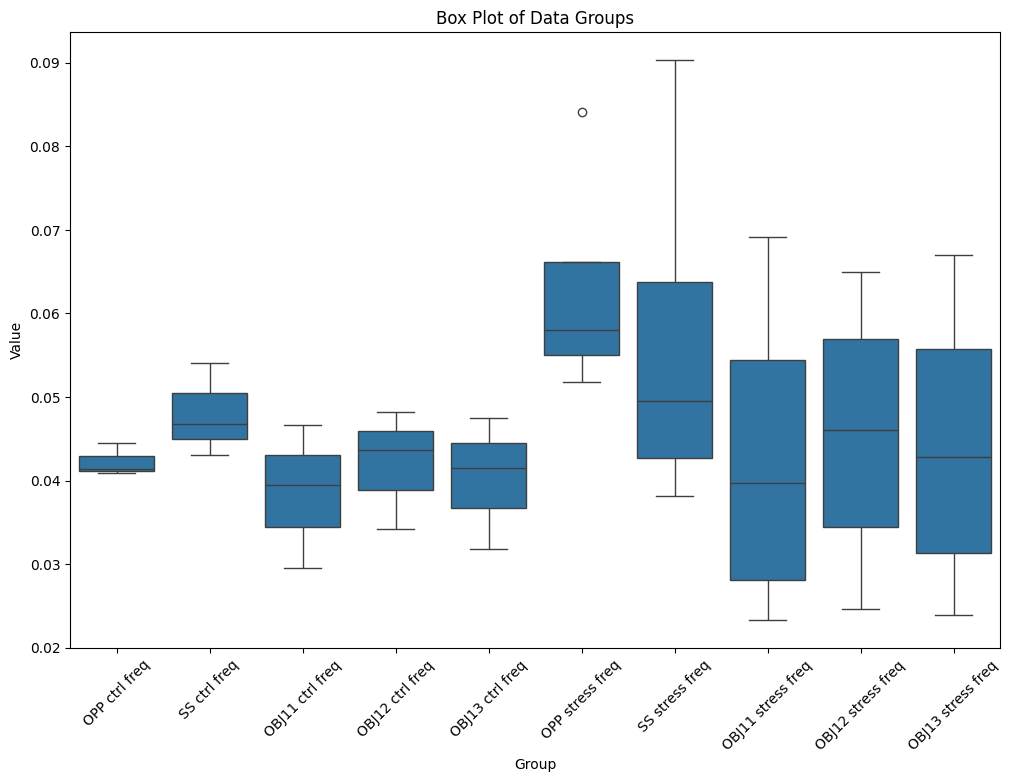

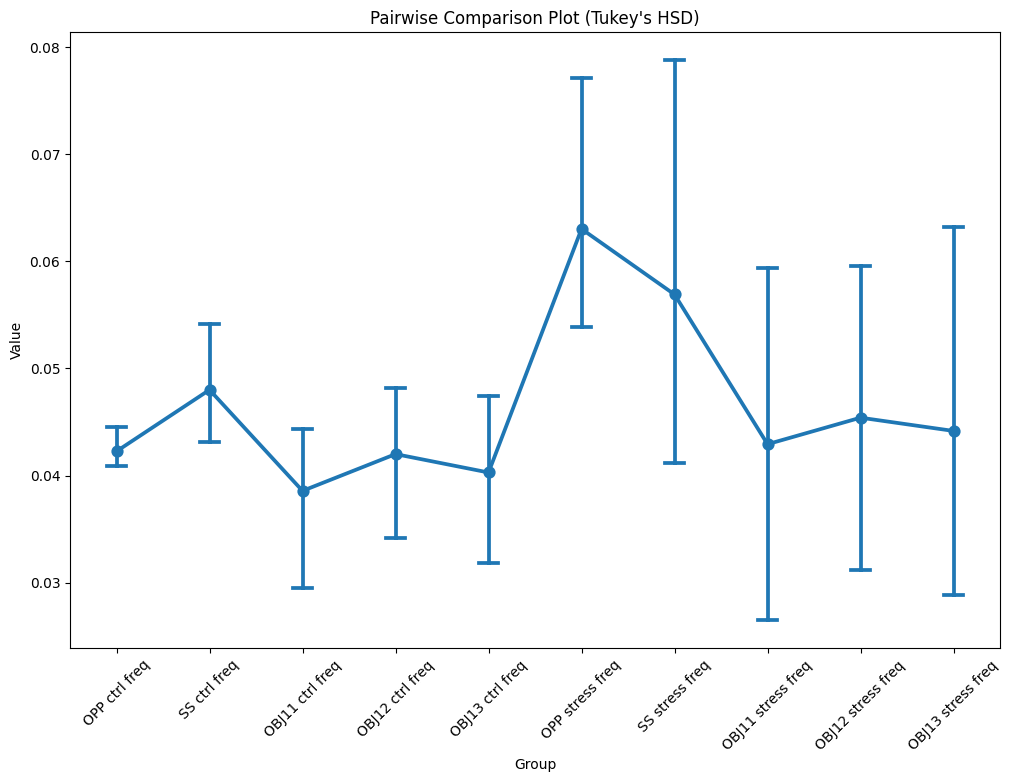

In [725]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from itertools import combinations
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

categories = [
    "OPP ctrl freq", 
    "SS ctrl freq", 
    "OBJ11 ctrl freq", 
    "OBJ12 ctrl freq", 
    "OBJ13 ctrl freq",
    "OPP stress freq", 
    "SS stress freq", 
    "OBJ11 stress freq",
    "OBJ12 stress freq",
    "OBJ13 stress freq"
    
    
]

data = [
    [0.04450809842, 0.04138767291, 0.04088509202],
    [0.0541, 0.0468, 0.0431],
    [0.0395, 0.0467, 0.0295],
    [0.0436, 0.0482, 0.0342],
    [0.04155, 0.04745, 0.03185],
    [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    [0.0382, 0.0549, 0.0903, 0.0442],
    [0.0233, 0.0496, 0.0691, 0.0297],
    [0.0246, 0.0543, 0.0649, 0.0378],
    [0.02395, 0.05195, 0.067,0.03375],
]

# Combine data and categories into a DataFrame
df_list = []
for i, values in enumerate(data):
    category = categories[i]
    df_list.extend([(category, value) for value in values])

df = pd.DataFrame(df_list, columns=['Group', 'Value'])

# Kruskal-Wallis test
kruskal_stat, kruskal_p_value = stats.kruskal(*data)
print(f"Kruskal-Wallis Test: p-value = {kruskal_p_value}")

# ANOVA
anova_stat, anova_p_value = stats.f_oneway(*data)
print(f"ANOVA: p-value = {anova_p_value}")

# Pairwise Mann-Whitney U tests
for (group1, values1), (group2, values2) in combinations(zip(categories, data), 2):
    mw_stat, mw_p_value = stats.mannwhitneyu(values1, values2)
    print(f"Mann-Whitney U Test between {group1} and {group2}: p-value = {mw_p_value}")

# Pairwise t-tests
for (group1, values1), (group2, values2) in combinations(zip(categories, data), 2):
    t_stat, t_p_value = stats.ttest_ind(values1, values2)
    print(f"T-Test between {group1} and {group2}: p-value = {t_p_value}")

# Tukey's test using pingouin
df_tukey = pg.pairwise_tukey(data=df, dv='Value', between='Group')
print("Tukey's Test Results:")
print(df_tukey)

# Box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Group', y='Value', data=df)
plt.title('Box Plot of Data Groups')
plt.xticks(rotation=45)
plt.show()

# Pairwise comparison plot (Tukey's HSD)
plt.figure(figsize=(12, 8))
sns.pointplot(x='Group', y='Value', data=df, capsize=0.2)
plt.title('Pairwise Comparison Plot (Tukey\'s HSD)')
plt.xticks(rotation=45)
plt.show()


C:\Users\Samara\AppData\Local\Temp\ipykernel_25976\2737342575.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_melted = pd.concat([df_melted, pd.DataFrame({'Value': values, 'Factor': category})], ignore_index=True)
C:\Users\Samara\AppData\Local\Temp\ipykernel_25976\2737342575.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Factor', y='Value', data=df_melted, ci='sd', capsize=0.1)
C:\Users\Samara\AppData\Local\Temp\ipykernel_25976\2737342575.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

ANOVA Table:
             sum_sq   df         F   PR(>F)
C(Factor)  0.000442  1.0  8.933131  0.02026
Residual   0.000346  7.0       NaN      NaN

Tukey's HSD Test:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2      meandiff p-adj  lower  upper  reject
-------------------------------------------------------------------
obj ctrl freq social ctrl freq   0.0149 0.0203 0.0031 0.0266   True
-------------------------------------------------------------------


TypeError: '<' not supported between instances of 'str' and 'float'

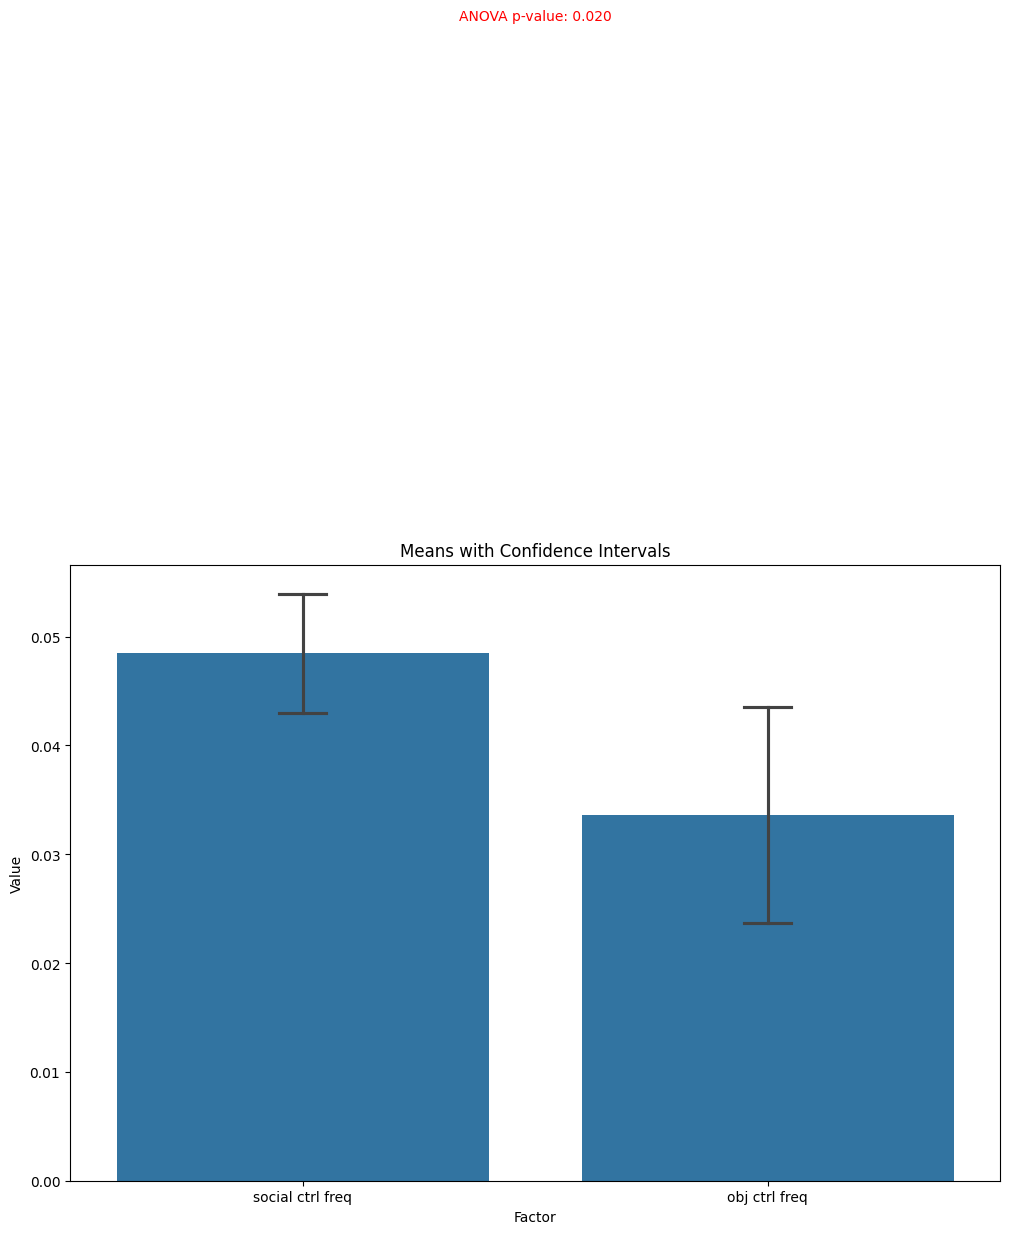

In [723]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

categories = [
    "social ctrl freq",  
    "obj ctrl freq",
    "social stress freq",  
    "obj stress freq" 
]

data = [
    [0.04450809842, 0.05638767291, 0.04588509202, 0.0541, 0.0468, 0.0431],
    [0.037, 0.0414, 0.0224],
    [0.06709448191, 0.05581633536, 0.08514263508, 0.05802528021, 0.0382, 0.0549, 0.0903, 0.0442],
    [0.0209, 0.0452, 0.0565, 0.0273]
]

# Convert the data to long format using the pandas melt function
df_melted = pd.DataFrame(columns=['Value', 'Factor'])
for i, category in enumerate(categories):
    if "ctrl" in category:
        values = [value for value in data[i] if value is not None]
        df_melted = pd.concat([df_melted, pd.DataFrame({'Value': values, 'Factor': category})], ignore_index=True)

# Explode the list in the 'Value' column
df_melted = df_melted.explode('Value')

# Perform two-way ANOVA
formula = 'Value ~ C(Factor)'
model = ols(formula, df_melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA Table:")
print(anova_table)

# Perform Tukey's post hoc test for multiple comparisons
m_comp = pairwise_tukeyhsd(endog=df_melted['Value'], groups=df_melted['Factor'], alpha=0.05)
print("\nTukey's HSD Test:")
print(m_comp)

# Plotting the means and confidence intervals
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Factor', y='Value', data=df_melted, ci='sd', capsize=0.1)
plt.title('Means with Confidence Intervals')
plt.xlabel('Factor')
plt.ylabel('Value')

# Print ANOVA results on the plot
anova_p_value = anova_table['PR(>F)'][0]
if anova_p_value < 0.05:
    plt.text(0.5, max(df_melted['Value']) + 0.05, 'ANOVA p-value: {:.3f}'.format(anova_p_value), ha='center', va='bottom', color='red')

# Print Tukey's HSD results on the plot
tukey_results_summary = m_comp.summary()
tukey_p_values = [result[-1] for result in tukey_results_summary.data]  # Access the last element containing p-values
for i, p_value in enumerate(tukey_p_values):
    if p_value < 0.05:
        plt.text(i, max(df_melted['Value']) + 0.1, '*', ha='center', va='bottom', color='red')

plt.show()

In [697]:
import pandas as pd
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Your data and categories
categories = [
    "opp ctrl ratio E", "opp ctrl ratio I",
    "ss ctrl ratio E", "ss ctrl ratio I",
    "object ctrl ratio E", "object ctrl ratio I",
    "opp stress ratio E", "opp stress ratio I",
    "ss stress ratio E", "ss stress ratio I",
    "object stress ratio E", "object stress ratio I"
]

data = [
    [0.5714285714, 0.6341463415, 0.5625, None],
    [0.4285714286, 0.3658536585, 0.4375, None],
    [0.6486486486, 0.4814814817, 0.7142857139, None],
    [0.3513513514, 0.5185185183, 0.2857142861, None],
    [0.7142857143, 0.5769230761, 0.5624999994, None],
    [0.2857142857, 0.4230769239, 0.4375000006, None],
    [0.4, 0.6, 0.48, 0.6666666667],
    [0.6, 0.4, 0.52, 0.3333333333],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    [0.2105263166, 0.5789473689, 0.3636363632, 0.3333333333],
    [0.8181818179, 0.6363636366, 0.7999999995, 0.5555555556],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.4444444444]
]

# Create an empty DataFrame
df_melted = pd.DataFrame(columns=['Value', 'Factor'])

# Populate the DataFrame, excluding None values
for i, category in enumerate(categories):
    if " stress" in category:
        values = [value for value in data[i] if value is not None]
        if values:  # Exclude empty lists
            df_melted = pd.concat([df_melted, pd.DataFrame({'Value': values, 'Factor': category})], ignore_index=True)

# Explode the list in the 'Value' column
df_melted = df_melted.explode('Value')

# Perform two-way ANOVA using AnovaRM
aovrm = AnovaRM(df_melted, 'Value', 'Factor', aggregate_func='mean')
res_anova = aovrm.fit()

# Perform Tukey's post hoc test for multiple comparisons
m_comp = pairwise_tukeyhsd(endog=df_melted['Value'], groups=df_melted['Factor'], alpha=0.05)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Box plot
sns.boxplot(x='Factor', y='Value', data=df_melted, palette="Set3")
plt.title('Box Plot with ANOVA and Tukey Results')

# Adding ANOVA p-value to the plot
plt.text(0.5, 0.9, f'ANOVA p-value: {res_anova.anova_table["Pr > F"][0]:.4f}', ha='center', va='center', transform=plt.gca().transAxes)

# Adding Tukey's significance stars and lines
m_comp.plot_simultaneous(comparison_name=None, ax=plt.gca())

plt.show()


C:\Users\Samara\AppData\Local\Temp\ipykernel_25976\1438117950.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_melted = pd.concat([df_melted, pd.DataFrame({'Value': values, 'Factor': category})], ignore_index=True)


TypeError: argument of type 'NoneType' is not iterable

In [614]:
import numpy as np

def bootstrap_ci(data, n_iterations=1000, alpha=0.05):
    means = []
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    lower_bound = np.percentile(means, 100 * alpha / 2)
    upper_bound = np.percentile(means, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

# Example: Compare bootstrap CIs between two groups
group1_data = data["OPP ctrl inter"]
group2_data = data["SS ctrl inter"]

# Calculate bootstrap CIs
ci_group1 = bootstrap_ci(group1_data)
ci_group2 = bootstrap_ci(group2_data)

# Check if CIs overlap
if ci_group1[1] < ci_group2[0] or ci_group1[0] > ci_group2[1]:
    print("The bootstrap CIs do not overlap, suggesting a potential significant difference.")
else:
    print("The bootstrap CIs overlap, indicating no clear evidence of a significant difference.")


The bootstrap CIs overlap, indicating no clear evidence of a significant difference.


In [603]:
from itertools import combinations
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Given data
# Given data
categories = ["E/I opp ctrl", "E/I ss ctrl", "E/I obj ctr", "E/I opp stress", "E/I ss stress", "E/I obj stress"]

data = [
    [1.333333333, 1.846153846, 2.5],
    [1.733333333, 0.9285714293, 2.499999995],
    [1.285714286, 1.363636359, 1.285714283],
    [0.6666666667, 1.5, 0.9230769231, 2],
    [3.749999982, 0.7272727259, 1.750000004, 2],
    [4.499999993, 1.750000002, 3.999999988, 1.25]
]
# Remove None values
data = [[val for val in sublist if val is not None] for sublist in data]

# Perform pairwise Mann-Whitney U tests
for (category1, values1), (category2, values2) in combinations(zip(categories, data), 2):
    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(values1, values2)
    
    # Output the results with titles
    print(f"Comparison between {category1} and {category2}:")
    print("-----------------------------------------------------")
    print(f"Mann-Whitney U Statistic: {statistic}")
    print(f"Mann-Whitney U P-value: {p_value}")
    
    # Check the significance level (e.g., 0.05) and make a decision
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis. There is a significant difference between {category1} and {category2}.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant difference between {category1} and {category2}.")
    
    print()  # Separate results for better readability

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(np.concatenate(data), np.repeat(categories, [len(v) for v in data]))
print(tukey_results)


Comparison between E/I opp ctrl and E/I ss ctrl:
-----------------------------------------------------
Mann-Whitney U Statistic: 6.0
Mann-Whitney U P-value: 0.7
Fail to reject the null hypothesis. There is no significant difference between E/I opp ctrl and E/I ss ctrl.

Comparison between E/I opp ctrl and E/I obj ctr:
-----------------------------------------------------
Mann-Whitney U Statistic: 8.0
Mann-Whitney U P-value: 0.2
Fail to reject the null hypothesis. There is no significant difference between E/I opp ctrl and E/I obj ctr.

Comparison between E/I opp ctrl and E/I opp stress:
-----------------------------------------------------
Mann-Whitney U Statistic: 9.0
Mann-Whitney U P-value: 0.4
Fail to reject the null hypothesis. There is no significant difference between E/I opp ctrl and E/I opp stress.

Comparison between E/I opp ctrl and E/I ss stress:
-----------------------------------------------------
Mann-Whitney U Statistic: 6.0
Mann-Whitney U P-value: 1.0
Fail to reject the

In [599]:
!pip install statsmodels


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.8 MB 1.1 MB/s eta 0:00:09
   ------ --------------------------------- 1.6/9.8 MB 16.7 MB/s eta 0:00:01
   ---------------- ----------------------- 4.0/9.8 MB 28.4 MB/s eta 0:00:01
   ------------------------ --------------- 6.1/9.8 MB 39.3 MB/s eta 0:00:01
   ---------------------------------- ----- 8.4/9.8 MB 41.4 MB/s eta 0:00:01
   ---------------------------------------  9.8/9.8 MB 41.7 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 36.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.9 kB ? eta -:--:--
   --------------------------------------- 233.9/233.9 kB 14.0 MB/s eta 0:00:00


In [604]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Given data
data = {
    "OPP ctrl inter": [0.05750809842, 0.04238767291, 0.04388509202],
    "SS ctrl inter": [0.0541, 0.0468, 0.0431],
    "OBJ ctrl inter": [0.0377, 0.0431, 0.0297],
    "OPP stress inter": [0.06009448191, 0.05181633536, 0.08414263508, 0.05602528021],
    "SS stress inter": [0.0382, 0.0549, 0.0903, 0.0442],
    "OBJ inter": [0.0193, 0.0431, 0.0559, 0.032],
    "OPP ctrl non": [0.04799430568, 0.03354884803, 0.02755414292],
    "SS ctrl non": [0.0492, 0.0577, 0.0398],
    "OPP stress non": [0.05459450159, 0.04715059589, 0.07329311048, 0.04728079108],
    "SS stress non": [0.0271, 0.0541, 0.0774, 0.036]
}

# Convert data to a format suitable for Tukey's test
df = pd.DataFrame([(value, key) for key, values in data.items() for value in values], columns=["Value", "Category"])

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(df["Value"], df["Category"])
print(tukey_results)


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
  OBJ ctrl inter        OBJ inter   0.0007    1.0 -0.0388 0.0403  False
  OBJ ctrl inter   OPP ctrl inter   0.0111 0.9947 -0.0312 0.0534  False
  OBJ ctrl inter     OPP ctrl non  -0.0005    1.0 -0.0428 0.0418  False
  OBJ ctrl inter OPP stress inter   0.0262 0.4278 -0.0134 0.0658  False
  OBJ ctrl inter   OPP stress non   0.0187 0.8166 -0.0208 0.0583  False
  OBJ ctrl inter    SS ctrl inter   0.0112 0.9945 -0.0311 0.0535  False
  OBJ ctrl inter      SS ctrl non   0.0121 0.9904 -0.0302 0.0544  False
  OBJ ctrl inter  SS stress inter   0.0201 0.7549 -0.0195 0.0596  False
  OBJ ctrl inter    SS stress non   0.0118 0.9869 -0.0278 0.0514  False
       OBJ inter   OPP ctrl inter   0.0104 0.9948 -0.0292 0.0499  False
       OBJ inter     OPP ctrl non  -0.0012    1.0 -0.0408 0.0384

In [593]:
from itertools import combinations
from scipy.stats import mannwhitneyu, ttest_ind

# Given data
data = {
    "social ctrl E": [0.5714285714, 0.6341463415, 0.5625, 0.6486486486, 0.4814814817, 0.7142857139],
    "social stress E": [0.4, 0.6, 0.48, 0.6666666667, 0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667],
    "object ctrl E": [0.7142857143, 0.5769230761, 0.5624999994],
    "object stress E": [0.8181818179, 0.6363636366, 0.7999999995, 0.5555555556],
    "social ctrl I": [0.4285714286, 0.3658536585, 0.4375, 0.3513513514, 0.5185185183, 0.2857142861],
    "social stress I": [0.6, 0.4, 0.52, 0.3333333333, 0.2105263166, 0.5789473689, 0.3636363632, 0.3333333333],
    "object ctrl I": [0.2857142857, 0.4230769239, 0.4375000006],
    "object stress I": [0.1818181821, 0.3636363634, 0.2000000005, 0.4444444444]
}

# Perform pairwise Mann-Whitney U tests and Student's t-tests
for (dataset1, values1), (dataset2, values2) in combinations(data.items(), 2):
    
    # Perform Mann-Whitney U test
    mw_statistic, mw_p_value = mannwhitneyu(values1, values2)
    
    # Perform Student's t-test
    t_statistic, t_p_value = ttest_ind(values1, values2)
    
    # Output the results with titles
    print(f"Comparison between {dataset1} and {dataset2}:")
    print("-----------------------------------------------------")
    print(f"Mann-Whitney U Statistic: {mw_statistic}")
    print(f"Mann-Whitney U P-value: {mw_p_value}")
    print(f"Student's t-test Statistic: {t_statistic}")
    print(f"Student's t-test P-value: {t_p_value}")
    
    # Check the significance level (e.g., 0.05) and make a decision for Mann-Whitney U test
    alpha_mw = 0.05
    if mw_p_value < alpha_mw:
        print(f"Reject the null hypothesis (Mann-Whitney). There is a significant difference between {dataset1} and {dataset2}.")
    else:
        print(f"Fail to reject the null hypothesis (Mann-Whitney). There is no significant difference between {dataset1} and {dataset2}.")
    
    # Check the significance level (e.g., 0.05) and make a decision for Student's t-test
    alpha_t = 0.05
    if t_p_value < alpha_t:
        print(f"Reject the null hypothesis (t-test). There is a significant difference between {dataset1} and {dataset2}.")
    else:
        print(f"Fail to reject the null hypothesis (t-test). There is no significant difference between {dataset1} and {dataset2}.")
    
    print()  # Separate results for better readability


Comparison between social ctrl E and social stress E:
-----------------------------------------------------
Mann-Whitney U Statistic: 25.0
Mann-Whitney U P-value: 0.9484759445469622
Student's t-test Statistic: 0.31072888291469514
Student's t-test P-value: 0.7613377971412794
Fail to reject the null hypothesis (Mann-Whitney). There is no significant difference between social ctrl E and social stress E.
Fail to reject the null hypothesis (t-test). There is no significant difference between social ctrl E and social stress E.

Comparison between social ctrl E and object ctrl E:
-----------------------------------------------------
Mann-Whitney U Statistic: 8.0
Mann-Whitney U P-value: 0.9047619047619047
Student's t-test Statistic: -0.2734188221234011
Student's t-test P-value: 0.7924227103013808
Fail to reject the null hypothesis (Mann-Whitney). There is no significant difference between social ctrl E and object ctrl E.
Fail to reject the null hypothesis (t-test). There is no significant diff

In [594]:
from itertools import combinations
from scipy.stats import mannwhitneyu, ttest_ind

# Given data
categories = ["opp ctrl E", "ss ctrl E", "opp stress E", "ss stress E", "object ctrl E", "object stress E",
              "opp ctrl I", "ss ctrl I", "opp stress I", "ss stress I", "object ctrl I", "object stress I"]

data = [
    [0.5714285714, 0.6341463415, 0.5625, None, None],
    [0.6486486486, 0.4814814817, 0.7142857139, None, None],
    [0.4, 0.6, 0.48, 0.6666666667, None],
    [0.7894736834, 0.4210526311, 0.6363636368, 0.6666666667, None],
    [0.7142857143, 0.5769230761, 0.5624999994, None, None],
    [0.8181818179, 0.6363636366, 0.7999999995, None, None],
    [0.4285714286, 0.3658536585, 0.4375, None, None],
    [0.3513513514, 0.5185185183, 0.2857142861, 0.5555555556, None],
    [0.6, 0.4, 0.52, None, None],
    [0.2105263166, 0.5789473689, 0.3636363632, None, 0.4444444444],
    [0.2857142857, 0.4230769239, 0.4375000006, 0.3333333333, None],
    [0.1818181821, 0.3636363634, 0.2000000005, 0.3333333333, None]
]

# Perform pairwise Mann-Whitney U tests and Student's t-tests
for (category1, values1), (category2, values2) in combinations(zip(categories, data), 2):
    
    # Remove None values
    values1_cleaned = [x for x in values1 if x is not None]
    values2_cleaned = [x for x in values2 if x is not None]
    
    # Perform Mann-Whitney U test
    mw_statistic, mw_p_value = mannwhitneyu(values1_cleaned, values2_cleaned)
    
    # Perform Student's t-test
    t_statistic, t_p_value = ttest_ind(values1_cleaned, values2_cleaned)
    
    # Output the results with titles
    print(f"Comparison between {category1} and {category2}:")
    print("-----------------------------------------------------")
    print(f"Mann-Whitney U Statistic: {mw_statistic}")
    print(f"Mann-Whitney U P-value: {mw_p_value}")
    print(f"Student's t-test Statistic: {t_statistic}")
    print(f"Student's t-test P-value: {t_p_value}")
    
    # Check the significance level (e.g., 0.05) and make a decision for Mann-Whitney U test
    alpha_mw = 0.05
    if mw_p_value < alpha_mw:
        print(f"Reject the null hypothesis (Mann-Whitney). There is a significant difference between {category1} and {category2}.")
    else:
        print(f"Fail to reject the null hypothesis (Mann-Whitney). There is no significant difference between {category1} and {category2}.")
    
    # Check the significance level (e.g., 0.05) and make a decision for Student's t-test
    alpha_t = 0.05
    if t_p_value < alpha_t:
        print(f"Reject the null hypothesis (t-test). There is a significant difference between {category1} and {category2}.")
    else:
        print(f"Fail to reject the null hypothesis (t-test). There is no significant difference between {category1} and {category2}.")
    
    print()  # Separate results for better readability


Comparison between opp ctrl E and ss ctrl E:
-----------------------------------------------------
Mann-Whitney U Statistic: 3.0
Mann-Whitney U P-value: 0.7
Student's t-test Statistic: -0.3491801631865339
Student's t-test P-value: 0.7445609533281954
Fail to reject the null hypothesis (Mann-Whitney). There is no significant difference between opp ctrl E and ss ctrl E.
Fail to reject the null hypothesis (t-test). There is no significant difference between opp ctrl E and ss ctrl E.

Comparison between opp ctrl E and opp stress E:
-----------------------------------------------------
Mann-Whitney U Statistic: 7.0
Mann-Whitney U P-value: 0.8571428571428571
Student's t-test Statistic: 0.7204506831621266
Student's t-test P-value: 0.5035118478502645
Fail to reject the null hypothesis (Mann-Whitney). There is no significant difference between opp ctrl E and opp stress E.
Fail to reject the null hypothesis (t-test). There is no significant difference between opp ctrl E and opp stress E.

Compari

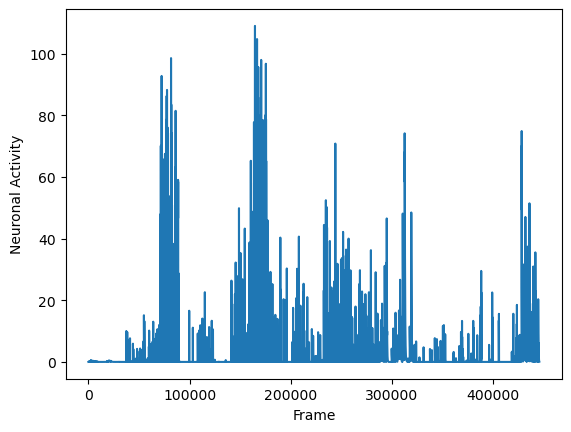

In [329]:
animal_id=animal_ids[0]
event_type = 'Mount'


events = ['Active groom','Active Invest','Mutual Invest','Passive groom','Mate','Mount','Passive Invest','Proximity']
behavioral_events = [aligned_events[event] for aligned_events in all_aligned_events]
timestamp_path = os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')



neuron_activity=all_deconvolved_datasets[4]
  
before_window=90
after_window=90
data=neuron_activity
flatten_data = data.flatten()


# Plot the data and mark significant events
plt.plot(flatten_data)
plt.xlabel("Frame")
plt.ylabel("Neuronal Activity")
plt.show()

In [335]:

# Assuming 'data' is your matrix
animal_id = animal_ids[4]
neuron_activity = all_deconvolved_datasets[4]

timestamp_path = os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
timestamps_df = pd.read_csv(timestamp_path)

# Assuming 'merged_timestamps' is the column containing timestamps
timestamps = timestamps_df['merged_timestamps'].values

# Calculate time per frame
time_per_frame = np.mean(np.diff(timestamps))

# Assuming 'neuron_activity' is your matrix
threshold_std = 2  # Adjust this multiplier as needed
time_per_frame = 0.1  # Adjust this based on your actual data

frequencies = []

num_neurons = neuron_activity.shape[1]
num_rows = int(np.ceil(num_neurons / 3))  # Assuming 3 subplots per row
fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), sharex=True)

# Loop through neurons
for neuron_index in range(neuron_activity.shape[1]):
    neuron_data = neuron_activity[neuron_index,:]  

    # Find peaks for the current neuron
    threshold = np.mean(neuron_data) + threshold_std * np.std(neuron_data)
    peaks, _ = find_peaks(neuron_data, height=threshold)

    # Calculate frequency (peaks per second)
    frequency = len(peaks) / (len(neuron_data) * time_per_frame)
    frequencies.append(frequency)

    # Plot on the corresponding subplot
    row_index = neuron_index // 3
    col_index = neuron_index % 3
    axs[row_index, col_index].plot(timestamps, neuron_data)
    axs[row_index, col_index].plot(timestamps[peaks], neuron_data[peaks], "x", label="significant events")
    axs[row_index, col_index].set_xlabel("Timestamp")
    axs[row_index, col_index].set_ylabel(f"Neuronal Activity - Neuron {neuron_index + 1}")
    axs[row_index, col_index].set_title(f"Frequency: {frequency:.2f} Hz")

average_frequency = np.mean(frequencies)

# List of behavior types
all_behaviors = all_aligned_events[animal_id]
behavior_types = ['Active groom', 'Active Invest', 'Mutual Invest', 'Passive groom', 'Mate', 'Mount', 'Passive Invest', 'Proximity']

# Create subplots for each behavior type
num_behaviors = len(behavior_types)
num_cols = 2  # Adjust as needed
num_rows = int(np.ceil(num_behaviors / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True)

# Loop through behavior types
for i, behavior_type in enumerate(behavior_types):
    row_index = i // num_cols
    col_index = i % num_cols

    # Plot the behavior type on the corresponding subplot
    axs[row_index, col_index].plot(timestamps, all_aligned_events[behavior_type])
    axs[row_index, col_index].set_title(f'Behavior Type: {behavior_type}')
    axs[row_index, col_index].set_xlabel('Timestamp Index')
    axs[row_index, col_index].set_ylabel('Behavior Value')  # Adjust ylabel as needed

# Hide any unused subplots
for j in range(num_behaviors, num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

ValueError: Image size of 1500x2970500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x2.9705e+06 with 1915 Axes>

In [ ]:

# Assuming 'data' is your matrix
animal_id = animal_ids[4]
neuron_activity = all_deconvolved_datasets[4]

timestamp_path = os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
timestamps_df = pd.read_csv(timestamp_path)

# Assuming 'merged_timestamps' is the column containing timestamps
timestamps = timestamps_df['merged_timestamps'].values

# Calculate time per frame
time_per_frame = np.mean(np.diff(timestamps))

# Assuming 'neuron_activity' is your matrix
threshold_std = 2  # Adjust this multiplier as needed
time_per_frame = 0.1  # Adjust this based on your actual data

frequencies = []

num_neurons = neuron_activity.shape[1]
num_rows = int(np.ceil(num_neurons / 3))  # Assuming 3 subplots per row
fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), sharex=True)
print(num_neurons)

In [ ]:
events = ['Active groom', 'Active Invest', 'Mutual Invest', 'Passive groom', 'Mate', 'Mount', 'Passive Invest', 'Proximity']

# Loop through all animal IDs and their corresponding dataframes
all_behavioral_bouts = []

for animal_index, animal_id in enumerate(animal_ids):
    timestamp_path = os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
    
    # Get the corresponding dataframe for the current animal_id
    current_df = all_aligned_events[animal_index]

    # Create a dictionary to store behavioral bouts for the current animal ID
    animal_behavior_dict = {'animal_id': animal_id, 'behavior_bouts': {}}

    # Loop through all events and store the corresponding behavioral bouts
    for event in events:
        behavioral_event = current_df[event]
        behavior_bouts = npa.start_and_stop_behavior_events(behavioral_event, timestamp_path)
        animal_behavior_dict['behavior_bouts'][event] = behavior_bouts

    # Append the dictionary to the list
    all_behavioral_bouts.append(animal_behavior_dict)


In [ ]:
import numpy as np

def extract_activity_around_event_position_data(neuron_activity, frame_timestamps, interaction_bouts, before_window, after_window, onset='start'):
    num_neurons, _ = neuron_activity.shape

    # Initialize list to store activity around events
    activity_during_events = []

    for i, bout in interaction_bouts.iterrows():
        start_frame_index, stop_frame_index = bout['start_frame_index'], bout['stop_frame_index']

        # Calculate adjusted window start and end points
        bout_length = stop_frame_index - start_frame_index

        if onset == 'start':
            window_start = int(start_frame_index - before_window)
            window_end = int(start_frame_index + after_window)
        elif onset == 'stop':
            window_start = int(stop_frame_index - before_window)
            window_end = int(stop_frame_index + after_window)
        else:
            raise ValueError("Invalid value for 'onset'. Use 'start' or 'stop'.")

        # Ensure the adjusted window is within the valid frame range
        window_start = max(0, window_start)
        window_end = min(neuron_activity.shape[1] - 1, window_end)

        # Extract activity within the adjusted window
        activity_window = neuron_activity[:, window_start:window_end + 1]

        # Append the activity window to the list
        activity_during_events.append(activity_window)

    # Determine the maximum length among all events
    max_length = max(activity_window.shape[1] for activity_window in activity_during_events)

    # Initialize array to store padded activity
    padded_activity_during_events = np.zeros((num_neurons, len(interaction_bouts), max_length))

    # Pad and assign the activity windows to the corresponding part of the array
    for i, activity_window in enumerate(activity_during_events):
        padding = max_length - activity_window.shape[1]
        padded_activity_during_events[:, i, :] = np.pad(activity_window, ((0, 0), (0, padding)), mode='constant')

    return padded_activity_during_events

# Example usage:

#print(result)


## Plot normalized interaction bouts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_activity_for_neuron_index(extracted_activity, neuron_indices, title, before_window, after_window):
    num_neurons, num_behav_bouts, max_length = extracted_activity.shape

    # Determine the number of rows and columns for the grid
    num_plots = len(neuron_indices)
    num_cols = min(num_plots, 3)  # You can adjust the number of columns as needed
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Loop over provided neuron indices
    for idx, neuron_id in enumerate(neuron_indices, start=1):
        if neuron_id < 0 or neuron_id >= num_neurons:
            print(f"Invalid neuron index: {neuron_id}. Skipping.")
            continue

        # Compute mean and standard deviation for the current neuron
        mean_activity = np.mean(extracted_activity, axis=1)
        individual_std_activity = np.std(extracted_activity, axis=1)
        sample_size = len(extracted_activity)
        sem = individual_std_activity / np.sqrt(sample_size)

        # Specify color with lower alpha for transparency
        color = plt.cm.viridis(neuron_id / num_neurons)  # Adjust the colormap as needed
        color_with_transparency = (*color[:-1], 0.2)  # Set alpha to 0.2 for transparency

        # Create subplots in a grid
        plt.subplot(num_rows, num_cols, idx)

        # Plot mean activity with error bars
        plt.errorbar(
            np.arange(-max_length // 2, max_length // 2),
            mean_activity[neuron_id, :],
            yerr=sem[neuron_id, :],
            label=title,
            color=color_with_transparency  # Use the color with transparency
        )

     


        plt.xlabel('Interaction onset')
        plt.ylabel('Mean Neuron Activity')
        plt.title(f'Neuron {neuron_id + 1}')  # Add neuron ID to the title
        plt.xticks([-before_window, 0, after_window], [-before_window, 0, after_window])  # Set x-axis labels
       



    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

# Example usage

# Example usage


## Overlay bouts and traces

In [ ]:
# Function to plot the data and overlay interactions
def plot_data_with_behavior(dataset, interaction_bouts):
    plt.plot(dataset['start_timestamp'], label='Example Variable')

    # Overlay transparent rectangles for each interaction bout
    for index, row in interaction_bouts.iterrows():
        plt.axvspan(row['start_timestamp'], row['stop_timestamp'], color='red', alpha=0.2)

    plt.xlabel('Time')
    plt.ylabel('Data')
    plt.title('Example Plot with Interaction Overlays')
    plt.legend()
    plt.show()
 

# Function to allow the user to select an animal_id
def select_animal_id():
    print("Available animal IDs:")
    for idx, animal_id in enumerate(animal_ids):
        print(f"{idx + 1}. {animal_id}")

    selected_idx = int(input("Enter the index of the desired animal_id: ")) - 1
    selected_animal_id = animal_ids[selected_idx]
    return selected_animal_id

# Example usage
selected_animal_id = 'DP6'

# Find the index of the selected animal_id in the list
selected_animal_idx = animal_ids.index(selected_animal_id)

# Get the corresponding dataset and interaction bouts
selected_dataset = all_datasets[selected_animal_idx]
selected_interaction_bouts = all_behavioral_bouts[selected_animal_idx]

selected_dataset = all_datasets[5]
selected_interaction_bouts = all_behavioral_bouts[5]['behavior_bouts']['Proximity']
animal_id=selected_animal_id 
selected_timestamp_path= os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
print(selected_interaction_bouts)
# Plot the data with interaction overlays
plot_data_with_behavior(selected_dataset, selected_interaction_bouts)

In [ ]:
animal_id=selected_animal_id 
selected_timestamp_path= os.path.join(parent_path, animal_id, 'all', 'img', 'timeStamps.csv')
dataset=selected_dataset
bouts=selected_interaction_bouts
# Assuming the MaskedArray has structured fields, adjust the field names accordingly


timestamps=pd.read_csv(selected_timestamp_path)['merged_timestamps']
num_columns = dataset.shape[0]
print(num_columns)
# Plot individual columns as traces
for col_index in range(num_columns):
    plt.plot(timestamps, dataset[col_index,:], label=f'Column {col_index + 1} Trace')

# Overlay transparent rectangles for each interaction bout
#for index, row in bouts.iterrows():
    #plt.axvspan(row['start_timestamp'], row['stop_timestamp'], color='red', alpha=0.2)

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Example Plot with Interaction Overlays')

# MISC


## Check that minian and imaging timestamps are same length (because of downsampling etc) and adjust if needed)

In [52]:
frames={}
for animal_index, animal_id in enumerate(animal_ids):
    neuron_activity = all_deconvolved_datasets[animal_index]
    
    behav_timestamp_path = os.path.join(parent_path, str(animal_id), 'all', 'behav', 'timeStamps.csv')
    img_timestamp_path = os.path.join(parent_path, str(animal_id), 'all', 'img', 'timeStamps.csv')
    
    img_timestamps_df = pd.read_csv(img_timestamp_path)
    frames_minian = neuron_activity.shape[1]
    frames_timestamp = len(img_timestamps_df)

    # Check if downsampling is needed
    if frames_minian != frames_timestamp:
        # Downsample img_timestamps_df to match the frame count
        img_timestamps_df = img_timestamps_df.iloc[::2]
        frames_timestamp = len(img_timestamps_df)
        img_timestamps_df.to_csv(img_timestamp_path, index=False)

        

    
    frames[animal_id] = { 'frames_minian': frames_minian, 'frames_timestamp': frames_timestamp}

for animal_id, frames in frames.items():
    print(f"Animal ID: {animal_id}")
    print("Frames minian:", frames['frames_minian'])
    print("Frames timestamp:", frames['frames_timestamp'])
    print()
    

Animal ID: DP2
Frames minian: 14340
Frames timestamp: 14340

Animal ID: DP3
Frames minian: 18480
Frames timestamp: 18480

Animal ID: DP4
Frames minian: 14297
Frames timestamp: 14297

Animal ID: DP5
Frames minian: 14298
Frames timestamp: 14298

Animal ID: DP9
Frames minian: 17823
Frames timestamp: 17823

Animal ID: DP14
Frames minian: 24871
Frames timestamp: 24871

Animal ID: DP10
Frames minian: 19087
Frames timestamp: 19087

Animal ID: DP15
Frames minian: 15536
Frames timestamp: 15536



In [ ]:
behavior_types = ['Active groom', 'Active Invest', 'Mutual Invest', 'Passive groom', 'Mate', 'Mount', 'Passive Invest', 'Proximity']
behavior_type='Mate'
behavior_index=npa.get_index(events,behavior_type)

inhibited=all_behaviors[behavior_index][all_percentage_inhibited_index]
excited=all_behaviors[behavior_index][all_percentage_excited_index]
not_sig=all_behaviors[behavior_index][all_percentage_not_significant_index]

# Plotting options
animal_ids = ['DP2', 'DP3', 'DP4', 'DP5','DP6','DP9', 'DP11', 'DP14','DP10', 'DP15']  # List of animal_ids to loop through #stress = ['DP9', 'DP11', 'DP14'] non-stress = ['DP10', 'DP12', 'DP15']
stress_animals = ['DP4', 'DP5', 'DP6','DP9', 'DP11', 'DP14']  # Replace with the actual animal IDs to plot
non_stress_animals = ['DP2', 'DP3','DP10', 'DP15'] # Replace with the actual animal IDs to plot

    
# Initialize lists to store percentages for each category
inhibited_stress = []
excited_stress = []
not_sig_stress = []

inhibited_non_stress = []
excited_non_stress = []
not_sig_non_stress = []

# Iterate through stress animals
stress_index_ids = [animal_ids.index(animal) for animal in stress_animals]
for stress_index_id in stress_index_ids:
    # Use lists to store percentages for each category
    inhibited_stress.append(inhibited[stress_index_id]/2)
    excited_stress.append(excited[stress_index_id]/2)
    not_sig_stress.append(not_sig[stress_index_id]/2)

# Similarly, iterate through non-stress animals
index_ids_non_stress = [animal_ids.index(animal) for animal in non_stress_animals]
for index_id in index_ids_non_stress:
    # Use lists to store percentages for each category
    inhibited_non_stress.append(inhibited[index_id]/2)
    excited_non_stress.append(excited[index_id]/2)
    not_sig_non_stress.append(not_sig[index_id]/2)


# Calculate averages for stress and non-stress animals
average_inhibited_stress = np.mean(inhibited_stress, axis=0)
average_excited_stress = np.mean(excited_stress, axis=0)
average_not_significant_stress = np.mean(not_sig_stress, axis=0)

average_inhibited_non_stress = np.mean(inhibited_non_stress, axis=0)
average_excited_non_stress = np.mean(excited_non_stress, axis=0)
average_not_significant_non_stress = np.mean(not_sig_non_stress, axis=0)

# Calculate standard errors for error bars
sem_inhibited_stress = np.std(inhibited_stress, axis=0) / np.sqrt(len(inhibited_stress))
sem_excited_stress = np.std(excited_stress, axis=0) / np.sqrt(len(excited_stress))
sem_not_significant_stress = np.std(not_sig_stress, axis=0) / np.sqrt(len(not_sig_stress))

sem_inhibited_non_stress = np.std(inhibited_non_stress, axis=0) / np.sqrt(len(inhibited_non_stress))
sem_excited_non_stress = np.std(excited_non_stress, axis=0) / np.sqrt(len(excited_non_stress))
sem_not_significant_non_stress = np.std(not_sig_non_stress, axis=0) / np.sqrt(len(not_sig_non_stress))

#Plotting
labels = ['Non resp', 'Inhib', 'Excit', 'Non resp- stress', 'Inhib- stress', 'Excit - stress']
fig, ax = plt.subplots(figsize=(3, 5))

x_positions_non_resp_non_stress =1
x_positions_inhib_non_stress =2
x_positions_excit_non_stress =3
x_positions_non_resp_stress =5
x_positions_inhib_stress =6
x_positions_excit_stress =7

# x positions for bars
x_positions = [x_positions_non_resp_non_stress, x_positions_inhib_non_stress, x_positions_excit_non_stress,
               x_positions_non_resp_stress, x_positions_inhib_stress, x_positions_excit_stress]
transparent_blues = [(0, 0, 1, alpha) for alpha in [0.3, 0.5, 0.7]]
transparent_reds = [(1, 0, 0, alpha) for alpha in [0.3, 0.5, 0.7]]

bar_colors_new = transparent_blues + transparent_reds


# Combine data for all animals (stress and non-stress)
bar_colors = [plt.cm.Blues(np.linspace(0.2, 0.8, 3)), plt.cm.Reds(np.linspace(0.2, 0.8, 3))]


average_all = [average_not_significant_non_stress, average_inhibited_non_stress, average_excited_non_stress,
               average_not_significant_stress, average_inhibited_stress, average_excited_stress]
sem_all = [sem_not_significant_non_stress, sem_inhibited_non_stress, sem_excited_non_stress,
           sem_not_significant_stress, sem_inhibited_stress, sem_excited_stress]


ax.bar(x_positions, average_all, yerr=sem_all, capsize=5, color=bar_colors_new, width=0.8)



for y in range (len(not_sig_non_stress)):
    y_values = not_sig_stress[y]
    ax.scatter(x_positions_non_resp_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
for y in range (len(inhibited_non_stress)):
    y_values = inhibited_stress[y]
    ax.scatter(x_positions_inhib_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
for y in range (len(excited_non_stress)):
    y_values = excited_non_stress[y]
    ax.scatter(x_positions_excit_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')

for y in range (len(not_sig_stress)):
    y_values = not_sig_stress[y]
    ax.scatter(x_positions_non_resp_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
for y in range (len(inhibited_stress)):
    y_values = inhibited_stress[y]
    ax.scatter(x_positions_inhib_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
for y in range (len(excited_stress)):
    y_values = excited_stress[y]
    ax.scatter(x_positions_excit_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    

ax.set_xticks(x_positions)  # Set the x-axis ticks to the specified positions
ax.set_xticklabels(labels)  # Set the labels for each x-axis tick
ax.set_xlabel('Cell Types')
ax.set_ylabel('Average Cell Percentages')
ax.set_title('Average Distribution of Cell Types - All Animals')
ax.set_ylim(0, 100)  # Set y-axis limits

plt.show()
plt.tight_layout()
plt.show()


In [ ]:
# Function to generate subplot for a given behavior type
def generate_subplot(behavior_type, events, all_behaviors, all_percentage_inhibited_index, 
                     all_percentage_excited_index, all_percentage_not_significant_index):
    behavior_index = npa.get_index(events, behavior_type)

    inhibited = all_behaviors[behavior_index][all_percentage_inhibited_index]
    excited = all_behaviors[behavior_index][all_percentage_excited_index]
    not_sig = all_behaviors[behavior_index][all_percentage_not_significant_index]

       # Plotting options
    animal_ids = ['DP2', 'DP3', 'DP4', 'DP5','DP6','DP9', 'DP11', 'DP14','DP10', 'DP15']  # List of animal_ids to loop through #stress = ['DP9', 'DP11', 'DP14'] non-stress = ['DP10', 'DP12', 'DP15']
    stress_animals = ['DP4', 'DP5', 'DP6','DP9', 'DP11', 'DP14']  # Replace with the actual animal IDs to plot
    non_stress_animals = ['DP2', 'DP3','DP10', 'DP15'] # Replace with the actual animal IDs to plot


    # Initialize lists to store percentages for each category
    inhibited_stress = []
    excited_stress = []
    not_sig_stress = []

    inhibited_non_stress = []
    excited_non_stress = []
    not_sig_non_stress = []

    # Iterate through stress animals
    stress_index_ids = [animal_ids.index(animal) for animal in stress_animals]
    for stress_index_id in stress_index_ids:
        # Use lists to store percentages for each category
        inhibited_stress.append(inhibited[stress_index_id]/2)
        excited_stress.append(excited[stress_index_id]/2)
        not_sig_stress.append(not_sig[stress_index_id]/2)

    # Similarly, iterate through non-stress animals
    index_ids_non_stress = [animal_ids.index(animal) for animal in non_stress_animals]
    for index_id in index_ids_non_stress:
        # Use lists to store percentages for each category
        inhibited_non_stress.append(inhibited[index_id]/2)
        excited_non_stress.append(excited[index_id]/2)
        not_sig_non_stress.append(not_sig[index_id]/2)


    # Calculate averages for stress and non-stress animals
    average_inhibited_stress = np.mean(inhibited_stress, axis=0)
    average_excited_stress = np.mean(excited_stress, axis=0)
    average_not_significant_stress = np.mean(not_sig_stress, axis=0)

    average_inhibited_non_stress = np.mean(inhibited_non_stress, axis=0)
    average_excited_non_stress = np.mean(excited_non_stress, axis=0)
    average_not_significant_non_stress = np.mean(not_sig_non_stress, axis=0)

    # Calculate standard errors for error bars
    sem_inhibited_stress = np.std(inhibited_stress, axis=0) / np.sqrt(len(inhibited_stress))
    sem_excited_stress = np.std(excited_stress, axis=0) / np.sqrt(len(excited_stress))
    sem_not_significant_stress = np.std(not_sig_stress, axis=0) / np.sqrt(len(not_sig_stress))

    sem_inhibited_non_stress = np.std(inhibited_non_stress, axis=0) / np.sqrt(len(inhibited_non_stress))
    sem_excited_non_stress = np.std(excited_non_stress, axis=0) / np.sqrt(len(excited_non_stress))
    sem_not_significant_non_stress = np.std(not_sig_non_stress, axis=0) / np.sqrt(len(not_sig_non_stress))
    
    #Plotting
    labels = ['Non resp', 'Inhib', 'Excit', 'Non resp- stress', 'Inhib- stress', 'Excit - stress']
    fig, ax = plt.subplots(figsize=(2, 3))

    x_positions_non_resp_non_stress =1
    x_positions_inhib_non_stress =2
    x_positions_excit_non_stress =3
    x_positions_non_resp_stress =5
    x_positions_inhib_stress =6
    x_positions_excit_stress =7

    # x positions for bars
    x_positions = [x_positions_non_resp_non_stress, x_positions_inhib_non_stress, x_positions_excit_non_stress,
                   x_positions_non_resp_stress, x_positions_inhib_stress, x_positions_excit_stress]
    transparent_blues = [(0, 0, 1, alpha) for alpha in [0.3, 0.5, 0.7]]
    transparent_reds = [(1, 0, 0, alpha) for alpha in [0.3, 0.5, 0.7]]

    bar_colors_new = transparent_blues + transparent_reds


    # Combine data for all animals (stress and non-stress)
    bar_colors = [plt.cm.Blues(np.linspace(0.2, 0.8, 3)), plt.cm.Reds(np.linspace(0.2, 0.8, 3))]


    average_all = [average_not_significant_non_stress, average_inhibited_non_stress, average_excited_non_stress,
                   average_not_significant_stress, average_inhibited_stress, average_excited_stress]
    sem_all = [sem_not_significant_non_stress, sem_inhibited_non_stress, sem_excited_non_stress,
               sem_not_significant_stress, sem_inhibited_stress, sem_excited_stress]


    ax.bar(x_positions, average_all, yerr=sem_all, capsize=5, color=bar_colors_new, width=0.8)



    for y in range (len(not_sig_non_stress)):
        y_values = not_sig_stress[y]
        ax.scatter(x_positions_non_resp_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(inhibited_non_stress)):
        y_values = inhibited_stress[y]
        ax.scatter(x_positions_inhib_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(excited_non_stress)):
        y_values = excited_non_stress[y]
        ax.scatter(x_positions_excit_non_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')

    for y in range (len(not_sig_stress)):
        y_values = not_sig_stress[y]
        ax.scatter(x_positions_non_resp_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(inhibited_stress)):
        y_values = inhibited_stress[y]
        ax.scatter(x_positions_inhib_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')
    for y in range (len(excited_stress)):
        y_values = excited_stress[y]
        ax.scatter(x_positions_excit_stress, y_values, color='black', alpha=0.5, s=20, label='_nolegend_')


    ax.set_xticks(x_positions)  # Set the x-axis ticks to the specified positions
    ax.set_xticklabels(labels)  # Set the labels for each x-axis tick
    ax.set_xlabel('Cell Types')
    ax.set_ylabel('Average Cell Percentages')
    ax.set_title('Average Distribution of Cell Types - All Animals')
    ax.set_ylim(0, 100)  # Set y-axis limits

    return ax  # Return the subplot axis



In [ ]:

def process_behavioral_events(all_datasets, all_aligned_events, event_type='Active Invest', num_permutations=5):
    # Specify behavioral event type
    events = ['Active groom', 'Active Invest', 'Mutual Invest', 'Passive groom', 'Mate', 'Mount', 'Passive Invest', 'Proximity']
    if event_type not in events:
        raise ValueError("Invalid event_type. Choose one from the predefined events.")

    behavioral_events = [aligned_events[event_type] for aligned_events in all_aligned_events]

    # Initialize empty lists to store results for each animal_id
    all_auc_values = []
    all_inhibited_counts = []
    all_excited_counts = []
    all_not_significant_counts = []
    all_inhibited_cell_lists = []
    all_excited_cell_lists = []
    all_not_significant_cell_lists = []

    # Initialize lists to store percentages for each category
    all_percentage_inhibited = []
    all_percentage_excited = []
    all_percentage_not_significant = []

    for dataset, behavioral_event in zip(all_datasets, behavioral_events):
        neural_activity = (dataset - np.mean(dataset, axis=0)) / np.mean(dataset, axis=0)

        # Calculate AUC values for the actual neural activity
        auc_values, _, _ = npa.auc_roc_analysis(neural_activity, behavioral_event, plot=True)
        all_auc_values.append(auc_values)

        # Generate null distribution
        null_distribution = npa.generate_null_distribution(neural_activity, behavioral_event, num_permutations=num_permutations)

        # Determine significance thresholds
        alpha = 0.05
        lower_threshold = np.percentile(null_distribution, 2.5)
        upper_threshold = np.percentile(null_distribution, 97.5)

        # Count occurrences of each category
        inhibited_count = np.sum(auc_values < lower_threshold)
        excited_count = np.sum(auc_values > upper_threshold)
        not_significant_count = dataset.shape[0] - (inhibited_count + excited_count)

        # Append counts to lists
        all_inhibited_counts.append(inhibited_count)
        all_excited_counts.append(excited_count)
        all_not_significant_counts.append(not_significant_count)

        # Get indices for each category
        not_significant_cell_list = np.where((auc_values >= lower_threshold) & (auc_values <= upper_threshold))
        excited_cell_list = np.where(auc_values < lower_threshold)
        inhibited_cell_list = np.where(auc_values > lower_threshold)

        # Append indices to lists
        all_not_significant_cell_lists.append(not_significant_cell_list)
        all_excited_cell_lists.append(excited_cell_list)
        all_inhibited_cell_lists.append(inhibited_cell_list)

        # Calculate the total number of cells for this animal
        total_cells = dataset.shape[0]

        # Calculate percentages
        percentage_inhibited = (inhibited_count / total_cells) * 100
        percentage_excited = (excited_count / total_cells) * 100
        percentage_not_significant = (not_significant_count / total_cells) * 100

        # Append percentages to lists
        all_percentage_inhibited.append(percentage_inhibited)
        all_percentage_excited.append(percentage_excited)
        all_percentage_not_significant.append(percentage_not_significant)

    return (all_auc_values, all_inhibited_counts, all_excited_counts, all_not_significant_counts,
            all_inhibited_cell_lists, all_excited_cell_lists, all_not_significant_cell_lists,
            all_percentage_inhibited, all_percentage_excited, all_percentage_not_significant)

# Usage example:
# all_datasets, all_aligned_events, and other parameters should be defined before calling this function
results = npa.process_behavioral_events(all_datasets, all_aligned_events, event_type='Mate', num_permutations=5)


In [ ]:

def process_behavioral_events(all_datasets, all_aligned_events, event_type='Active Invest', num_permutations=5):
    # Specify behavioral event type
    events = ['Active groom', 'Active Invest', 'Mutual Invest', 'Passive groom', 'Mate', 'Mount', 'Passive Invest', 'Proximity']
    if event_type not in events:
        raise ValueError("Invalid event_type. Choose one from the predefined events.")

    behavioral_events = [aligned_events[event_type] for aligned_events in all_aligned_events]

    # Initialize empty lists to store results for each animal_id
    all_auc_values = []
    all_inhibited_counts = []
    all_excited_counts = []
    all_not_significant_counts = []
    all_inhibited_cell_lists = []
    all_excited_cell_lists = []
    all_not_significant_cell_lists = []

    # Initialize lists to store percentages for each category
    all_percentage_inhibited = []
    all_percentage_excited = []
    all_percentage_not_significant = []

    for dataset, behavioral_event in zip(all_datasets, behavioral_events):
        neural_activity = (dataset - np.mean(dataset, axis=0)) / np.mean(dataset, axis=0)

        # Calculate AUC values for the actual neural activity
        auc_values, _, _ = npa.auc_roc_analysis(neural_activity, behavioral_event, plot=True)
        all_auc_values.append(auc_values)

        # Generate null distribution
        null_distribution = npa.generate_null_distribution(neural_activity, behavioral_event, num_permutations=num_permutations)

        # Determine significance thresholds
        alpha = 0.05
        lower_threshold = np.percentile(null_distribution, 2.5)
        upper_threshold = np.percentile(null_distribution, 97.5)

        # Count occurrences of each category
        inhibited_count = np.sum(auc_values < lower_threshold)
        excited_count = np.sum(auc_values > upper_threshold)
        not_significant_count = dataset.shape[0] - (inhibited_count + excited_count)

        # Append counts to lists
        all_inhibited_counts.append(inhibited_count)
        all_excited_counts.append(excited_count)
        all_not_significant_counts.append(not_significant_count)

        # Get indices for each category
        not_significant_cell_list = np.where((auc_values >= lower_threshold) & (auc_values <= upper_threshold))
        excited_cell_list = np.where(auc_values < lower_threshold)
        inhibited_cell_list = np.where(auc_values > lower_threshold)

        # Append indices to lists
        all_not_significant_cell_lists.append(not_significant_cell_list)
        all_excited_cell_lists.append(excited_cell_list)
        all_inhibited_cell_lists.append(inhibited_cell_list)

        # Calculate the total number of cells for this animal
        total_cells = dataset.shape[0]

        # Calculate percentages
        percentage_inhibited = (inhibited_count / total_cells) * 100
        percentage_excited = (excited_count / total_cells) * 100
        percentage_not_significant = (not_significant_count / total_cells) * 100

        # Append percentages to lists
        all_percentage_inhibited.append(percentage_inhibited)
        all_percentage_excited.append(percentage_excited)
        all_percentage_not_significant.append(percentage_not_significant)

    return (all_auc_values, all_inhibited_counts, all_excited_counts, all_not_significant_counts,
            all_inhibited_cell_lists, all_excited_cell_lists, all_not_significant_cell_lists,
            all_percentage_inhibited, all_percentage_excited, all_percentage_not_significant)

# Usage example:
# all_datasets, all_aligned_events, and other parameters should be defined before calling this function
results = npa.process_behavioral_events(all_datasets, all_aligned_events, event_type='Mate', num_permutations=5)


In [ ]:
def plot_activity_for_neuron_index(extracted_activity, neuron_indices, title):
    num_neurons, num_behav_bouts, max_length = extracted_activity.shape

    # Loop over provided neuron indices
    for neuron_id in neuron_indices:
        if neuron_id < 0 or neuron_id >= num_neurons:
            print(f"Invalid neuron index: {neuron_id}. Skipping.")
            continue

        # Compute mean and standard deviation for the current neuron
        mean_activity = np.mean(extracted_activity, axis=1)
        individual_std_activity = np.std(extracted_activity, axis=1)
        sample_size=len(extracted_activity)
        sem = individual_std_activity / np.sqrt(sample_size)


        # Specify color with lower alpha for transparency
        color = plt.cm.viridis(neuron_id / num_neurons)  # Adjust the colormap as needed
        color_with_transparency = (*color[:-1], 0.2)  # Set alpha to 0.2 for transparency

        # Create a new figure for each neuron
        plt.figure(figsize=(8, 8))

        # Plot mean activity with error bars
        plt.errorbar(
            np.arange(max_length),
            mean_activity[neuron_id, :],
            yerr=sem[neuron_id, :],
            label=title,
            color=color_with_transparency  # Use the color with transparency
        )

        plt.xlabel('Interaction onset')
        plt.ylabel('Mean Neuron Activity')
        plt.title(title)

#plot_activity_all_neurons(activity_during_events_start, title='Start of Interaction')
#plot_activity_all_neurons(activity_during_events_end, title='End of Interaction')

#neuron_id=10
#plot_activity_single_neuron(activity_during_events_start, neuron_id, title='Start of Interaction')
#plot_activity_single_neuron(activity_during_events_end, neuron_id, title='End of Interaction')
excited_list=all_excited_cell_lists[0]
plot_activity_for_neuron_index(activity_during_events_end, excited_list[0], title='Activity during interaction onset')

In [ ]:
# Function to convert timestamp string to milliseconds
def timestamp_to_milliseconds(timestamp_str):
    time_format = "%H:%M:%S.%f"
    time_obj = datetime.strptime(timestamp_str, time_format)
    milliseconds = round((time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 1000 + time_obj.microsecond / 1000)
    return milliseconds

# Function to get the duration and fps of the video using OpenCV
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    cap.release()
    return duration, fps

# Function to plot a raster plot for interaction bouts
def plot_raster_plot(frame_timestamps, events, ax):
    for start, stop in events:
        # Find the closest frame index for each event time within a range
        start_frame_index = (frame_timestamps - start).abs().idxmin()
        stop_frame_index = (frame_timestamps - stop).abs().idxmin()

        # Plotting using frame indices
        ax.plot([start_frame_index, stop_frame_index], [1, 1], color='b', linewidth=3)

    ax.set_yticks([])
    ax.set_xlabel('Frame Index')

# Example usage
parent_path = "Z:\\DPC HONGWEI COLAB"
neural_imaging_subfolder = 'all\\img\\minian'

# Initialize empty lists to store results for each animal_id
all_interaction_bouts = []


for animal_id in animal_ids:
    # Extract and binarize behavioral bouts
    video_path = os.path.join(parent_path, animal_id, 'all\\behav', animal_id + '_downsampled.avi')
    video_duration_seconds, video_fps = get_video_info(video_path)

    # Read frame timestamps from the adjusted and concatenated timestamp file
    timestamp_file_directory = os.path.join(parent_path, animal_id, 'all\\img')
    timestamp_file_path = os.path.join(timestamp_file_directory, 'timeStamps.csv')

    if not os.path.exists(timestamp_file_path):
        # If it doesn't exist, concatenate timestamp files
        dataOrg.concatenate_timestamp_files(timestamp_file_directory)

    timestamp_data = pd.read_csv(timestamp_file_path)
    frame_timestamps = timestamp_data['Time Stamp (ms)']

    # Construct the path to the JSON file in the same directory as the video file
    json_file_path = os.path.join(os.path.dirname(video_path), 'events_log.json')

    # Load JSON data from each line
    events = []
    with open(json_file_path, 'r') as json_file:
        for line in json_file:
            event = json.loads(line)
            events.append(event)

    # Extract start and stop times of interaction bouts
    interaction_bouts = [(event['start_timestamp'], event['stop_timestamp']) for event in events if event['event'] == 'interaction']

    # Convert start and stop times to milliseconds
    interaction_bouts_in_ms = [
        (timestamp_to_milliseconds(start), timestamp_to_milliseconds(stop))
        for start, stop in interaction_bouts
    ]

    # Plotting the raster plot
    fig, ax = plt.subplots(figsize=(15, 2))
    plot_raster_plot(frame_timestamps, interaction_bouts_in_ms, ax)
    ax.set_title(f'Raster Plot for Interaction Bouts - Animal ID: {animal_id}')
    plt.show()

In [ ]:
not_significant_index = np.where((auc_values >= lower_threshold) & (auc_values <= upper_threshold))
excited_index=np.where(auc_values > lower_threshold)
inhibited_index=np.where(auc_values < lower_threshold)  
print(excited_index)

In [ ]:
def permute_activity(neural_activity):
    """
    Circularly permute neural activity to generate null distribution.

    Parameters:
    - neural_activity: 2D array (X neurons x frames)

    Returns:
    - permuted_activity: 2D array (X neurons x frames) after circular permutation
    """
    permuted_activity = np.roll(neural_activity, np.random.randint(neural_activity.shape[1]), axis=1)
    return permuted_activity

def generate_null_distribution(neural_activity, binarized_event_data, num_permutations=50):
    """
    Generate null distribution of AUC values from permuted neural activity.

    Parameters:
    - neural_activity: 2D array (X neurons x frames)
    - binarized_event_data: 1D array (frames)
    - num_permutations: Number of permutations to generate the null distribution

    Returns:
    - null_distribution: List of AUC values for each permutation
    """
    null_distribution = []

    for _ in range(num_permutations):
        permuted_activity = permute_activity(neural_activity)

        # Calculate AUC for each neuron
        auc_values, _, _ = auc_roc_analysis(permuted_activity, binarized_event_data)

        # Use the mean AUC value across neurons as the statistic for this permutation
        null_distribution.append(np.mean(auc_values))

    return null_distribution

def auc_roc_analysis(neural_activity, binarized_event_data, plot=True):
    """
    Perform AUC-ROC analysis for each neuron against binarized event data.

    Parameters:
    - neural_activity: 2D array (X neurons x frames)
    - binarized_event_data: 1D array (frames)
    - plot: Boolean, whether to plot ROC curves (default is True)

    Returns:
    - auc_values: List of AUC values for each neuron
    - fpr_values: List of false positive rates for each neuron
    - tpr_values: List of true positive rates for each neuron
    """

    auc_values = []
    fpr_values = []
    tpr_values = []

    for neuron_index in range(neural_activity.shape[0]):
        neuron_activity = neural_activity[neuron_index, :]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(binarized_event_data, neuron_activity)
        roc_auc = auc(fpr, tpr)

        auc_values.append(roc_auc)
        fpr_values.append(fpr)
        tpr_values.append(tpr)

        if plot:  # Plot ROC curve for each neuron (optional)
            plt.plot(fpr, tpr, lw=2, label=f'Neuron {neuron_index} (AUC = {roc_auc:.2f})')

    #if plot:# Plot ROC curve for all neurons (optional)
        #plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        #plt.xlabel('False Positive Rate')
        #plt.ylabel('True Positive Rate')
        #plt.title('Receiver Operating Characteristic (ROC) Curve')

    return auc_values, fpr_values, tpr_values

In [ ]:

def plot_activity_all_neurons(extracted_activity, title):
    mean_activityX = np.mean(extracted_activity, axis=1)
    mean_activity = np.mean(mean_activityX, axis=0)
    std_activity = np.std(mean_activityX, axis=0)
    max_length = extracted_activity.shape[2]
    color = plt.cm.viridis(0.5)  # Adjust the colormap and alpha as needed
    color_with_transparency = (*color[:-1], 0.2)  # Set alpha to 0.5 for transparency
    plt.figure(figsize=(8, 8))
    plt.errorbar(
        np.arange(max_length),
        mean_activity,
        yerr=std_activity,  # Use the standard deviation as error bars
        label='Mean Neuron Activity with Error Bars',
        color=color_with_transparency  # Use the color with transparency
    )
    
    plt.xlabel('Interaction onset')
    plt.ylabel('Mean Neuron Activity')
    plt.title(title)
   

def plot_activity_single_neuron(extracted_activity, neuron_id, title):
    mean_activity = np.mean(extracted_activity, axis=1)
    individual_std_activity = np.std(extracted_activity, axis=1)
    max_length = max(extracted_activity.shape)
    # Specify color with lower alpha for transparency
    color = plt.cm.viridis(neuron_id / extracted_activity.shape[0])  # Adjust the colormap as needed
    color_with_transparency = (*color[:-1], 0.2)  # Set alpha to 0.5 for transparency
    plt.figure(figsize=(8, 8))
    plt.errorbar(
        np.arange(max_length),
        mean_activity[neuron_id, :],
        yerr=individual_std_activity[neuron_id, :],
        label=f'Neuron {neuron_id}',
        color=color_with_transparency  # Use the color with transparency
    )

    plt.xlabel('Interaction onset')
    plt.ylabel('Mean Neuron Activity')
    plt.title(title)



In [ ]:
print(interaction_bouts)

In [ ]:
import os
import cv2
import pandas as pd
from datetime import datetime
import json

# Assuming video_path is the path to your video file
video_path = os.path.join(parent_path, animal_id, 'all\\behav', animal_id + '_downsampled.avi')
print(video_path)
json_file_path = os.path.join(parent_path, animal_id, 'all\\behav\\events_log.json')

# Function to convert timestamp string to milliseconds
def timestamp_to_milliseconds(timestamp_str):
    time_format = "%H:%M:%S.%f"
    time_obj = datetime.strptime(timestamp_str, time_format)
    milliseconds = round((time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 1000 + time_obj.microsecond / 1000)
    return milliseconds

# Function to get the duration and fps of the video using OpenCV
def get_video_info(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    cap.release()
    return duration, fps

# Get the duration and fps of the video
video_duration_seconds, video_fps = get_video_info(video_path)

print(f"Video Duration: {video_duration_seconds:.2f} seconds")
print(f"Frames Per Second (fps): {video_fps:.2f}")

# Read frame timestamps from the adjusted and concatenated timestamp file
timestamp_file_path = os.path.join(os.path.dirname(video_path), 'timeStamps.csv')
timestamp_data = pd.read_csv(timestamp_file_path)
frame_timestamps = timestamp_data['merged_timestamps']

# Construct the path to the JSON file in the same directory as the video file
json_file_path = os.path.join(os.path.dirname(video_path), 'events_log.json')

# Load JSON data from each line
events = []
with open(json_file_path, 'r') as json_file:
    for line in json_file:
        event = json.loads(line)
        events.append(event)

# Extract start and stop times of active invest events
active_invest_bouts = [(event['start_timestamp'], event['stop_timestamp']) for event in events if event['event'] == 'active invest.']

# Convert start and stop times to milliseconds
active_invest_bouts_in_ms = [
    (timestamp_to_milliseconds(start), timestamp_to_milliseconds(stop))
    for start, stop in active_invest_bouts
]

# Initialize arrays for interaction bouts and non-interaction bouts
interaction_bouts = []
non_interaction_bouts = []

# Iterate through each event
for start, stop in active_invest_bouts_in_ms:
    # Find the closest frame index for the start time within a range
    start_frame_index = (frame_timestamps - start).abs().idxmin()
    # Find the closest frame index for the stop time within a range
    stop_frame_index = (frame_timestamps - stop).abs().idxmin()
    matched_start_timestamp = frame_timestamps.iloc[(frame_timestamps - start).abs().idxmin()]
    # Find the closest frame index for the stop time within a range
    matched_stop_timestamp = frame_timestamps.iloc[(frame_timestamps - stop).abs().idxmin()]


    # Append interaction bout to the array
    interaction_bouts.append((start_frame_index, stop_frame_index))
# Iterate through non-interaction bouts
for i in range(len(interaction_bouts) - 1):
    start_frame_index = interaction_bouts[i][1]
    stop_frame_index = interaction_bouts[i + 1][0]

    # Add non-interaction bout from the end of the current interaction to the start of the next interaction
    non_interaction_bouts.append((start_frame_index + 1, stop_frame_index - 1))

# Add non-interaction bout from the start of the video to the start of the first interaction
non_interaction_bouts.insert(0, (0, interaction_bouts[0][0] - 1))

# Add non-interaction bout from the end of the last interaction to the end of the video
non_interaction_bouts.append((interaction_bouts[-1][1] + 1, len(frame_timestamps) - 1))

# Create binary vector arrays for interaction and non-interaction bouts
interaction_vector = [0] * len(frame_timestamps)
non_interaction_vector = [0] * len(frame_timestamps)

# Set values to 1 for frames within interaction bouts
for start, stop in interaction_bouts:
    interaction_vector[start:stop + 1] = [1] * (stop - start + 1)

# Set values to 1 for frames within non-interaction bouts
for start, stop in non_interaction_bouts:
    non_interaction_vector[start:stop + 1] = [1] * (stop - start + 1)


# Print the interaction bouts and non-interaction bouts
#print("Interaction Bouts:", interaction_bouts)
#print("Non-Interaction Bouts:", non_interaction_bouts)

# Print the binary vector arrays
#print("Interaction Vector:", interaction_vector)
#print("Non-Interaction Vector:", non_interaction_vector)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os

# Assuming you have loaded the neural signal, binary event vector, and frame timestamps
# delta_f, binary_event_vector, and frame_timestamps should be numpy arrays or pandas Series

imaging_data_folder = os.path.join(parent_path, animal_id, 'all\\img')
folder = imaging_data_folder

# Check if "timeStamps.csv" exists in the folder
timestamp_file_path = os.path.join(folder, 'timeStamps.csv')

if not os.path.exists(timestamp_file_path):
    # If the file doesn't exist, call the concatenate_timestamps function
    npa.concatenate_timestamps(folder, downsample=True)
else:
    print("Concatenated calcium imaging 'timeStamps.csv' file already exists. Skipping concatenation.")

# Convert frame timestamps to milliseconds
#timestamp_data = npa.load_timestamps(folder)
#frame_timestamps = timestamp_data['merged_timestamps']

# Calculate delta F over F
delta_f = (data - np.mean(data, axis=0)) / np.mean(data, axis=0)

# Calculate the Z-score in units of standard deviation
z_score = (delta_f - np.mean(delta_f, axis=0)) / np.std(delta_f, axis=0)

# Define the minimum and maximum values of the neural signal
min_threshold = np.min(delta_f)
max_threshold = np.max(delta_f)

# Create an array of threshold values spanning the range of the neural signal
thresholds = np.linspace(min_threshold, max_threshold, 100)

# Initialize arrays to store True Positive Rate (TPR) and False Positive Rate (FPR) values
tpr_values = []
fpr_values = []

# Calculate the True Positive Rate (TPR) and False Positive Rate (FPR) for each threshold
for threshold in thresholds:
    # Initialize arrays to store True Positive Rate (TPR) and False Positive Rate (FPR) values for each iteration
    iteration_tpr_values = []
    iteration_fpr_values = []

    # Apply binary threshold to the neural signal for each iteration (assumed to represent neurons)
    for iteration in range(delta_f.shape[0]):
        binary_prediction = (delta_f[iteration, :] > threshold).astype(int)
        fpr, tpr, _ = roc_curve(binary_event_vector, binary_prediction)
        
        # Interpolate TPR values to a common set of FPR values
        interpolated_tpr = np.interp(average_fpr, fpr, tpr)
        
        iteration_tpr_values.append(interpolated_tpr)
        iteration_fpr_values.append(average_fpr)

    # Calculate average TPR and FPR across iterations
    average_tpr = np.mean(iteration_tpr_values, axis=0)
    average_fpr = np.mean(iteration_fpr_values, axis=0)

    # Append average TPR and FPR values to the arrays
    tpr_values.append(average_tpr)
    fpr_values.append(average_fpr)

# Concatenate the FPR and TPR values
concatenated_fpr_values = np.concatenate(fpr_values)
concatenated_tpr_values = np.concatenate(tpr_values)

# Sort the FPR and TPR values
sorted_indices = np.argsort(concatenated_fpr_values)
sorted_fpr_values = concatenated_fpr_values[sorted_indices]
sorted_tpr_values = concatenated_tpr_values[sorted_indices]

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(sorted_fpr_values, sorted_tpr_values, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Calculate area under the ROC curve (auROC)
auROC = auc(sorted_fpr_values, sorted_tpr_values)
print(f"Area under the ROC Curve (auROC): {auROC:.4f}")

# Generate a null distribution of 1,000 auROC values from permuted calcium signals
null_distribution = []
for _ in range(50):
    permuted_signal = resample(delta_f, replace=False)
    iteration_tpr_values = []
    iteration_fpr_values = []

    for iteration in range(permuted_signal.shape[0]):
        binary_prediction_permuted = (permuted_signal[iteration, :] > threshold).astype(int)
        fpr_permuted, tpr_permuted, _ = roc_curve(binary_event_vector, binary_prediction_permuted)
        auroc_permuted = auc(fpr_permuted, tpr_permuted)
        iteration_tpr_values.append(tpr_permuted)
        iteration_fpr_values.append(fpr_permuted)

    average_tpr_permuted = np.mean(iteration_tpr_values, axis=0)
    average_fpr_permuted = np.mean(iteration_fpr_values, axis=0)
    null_distribution.append(auroc_permuted)

# Compare observed auROC to the null distribution
alpha = 0.05
lower_percentile = np.percentile(null_distribution, alpha / 2 * 100)
upper_percentile = np.percentile(null_distribution, (1 - alpha / 2) * 100)

# Check if the observed auROC is significantly different
if auROC < lower_percentile or auROC > upper_percentile:
    print("The neuron is significantly responsive.")
else:
    print("The neuron is not significantly responsive.")
